In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns 
%matplotlib inline 
from matplotlib import rc
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use(['ggplot'])
import squarify

# 주별표시 
from math import ceil
from datetime import datetime, timezone, timedelta
pd.options.display.max_rows=1000

#추천시스템
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
import platform
import missingno as msno
from datetime import datetime, timezone, timedelta
import pytz
from tqdm.notebook import tqdm as tqdm

import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.options.display.float_format = '{:.0f}'.format
pd.options.display.max_rows=1000

### 프로젝트 불러오기

In [2]:
df = pd.read_csv("과제수정DB.csv")

### 기본 구조 확인

In [3]:
print(f'기본 Dataset 구조 : {df.shape}')
print('='*80)
print(df.info())

기본 Dataset 구조 : (1469, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469 entries, 0 to 1468
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brandnm     1469 non-null   object
 1   goodsnm     1469 non-null   object
 2   USER        1469 non-null   object
 3   reg_date    1469 non-null   object
 4   order_date  1469 non-null   object
 5   p_type      1469 non-null   object
 6   sub_type    1469 non-null   object
 7   app_yn      1293 non-null   object
dtypes: object(8)
memory usage: 91.9+ KB
None


### 각 column별 의미
* brandnm: 브랜드명
* goodsnm: 아이템 명
* USER: 개별 유저 식별 값
* reg_date: 개별 유저 가입일
* order_date: 아이템 주문일
* P_type: 주문 상품 종류 (7일권 / 4일권)
* sub_type: 주문 상품 카테고리 (BA-가방/ O-아우터/ D-드레스/ T-상의/ B-하의/ TB-투피스)
* app_yn: 어플리케이션 사용 여부(Y-사용 / 공백-미사용)
####  - 의류,가방은 1회에 4일 또는 7일 대여

### 결측치 처리
* brandnm: 클로젯셰어 검색결과로 도출, 2개의 결측치는 예측 불가하여 입력 X
* reg_date: USER의 번호가 순차적인것을 짐작하여 입력

### app_yn에 'N' 넣어주기

In [4]:
df.app_yn.fillna('N', inplace=True)

## brandnm의 결측치 2가지 drop

<AxesSubplot:>

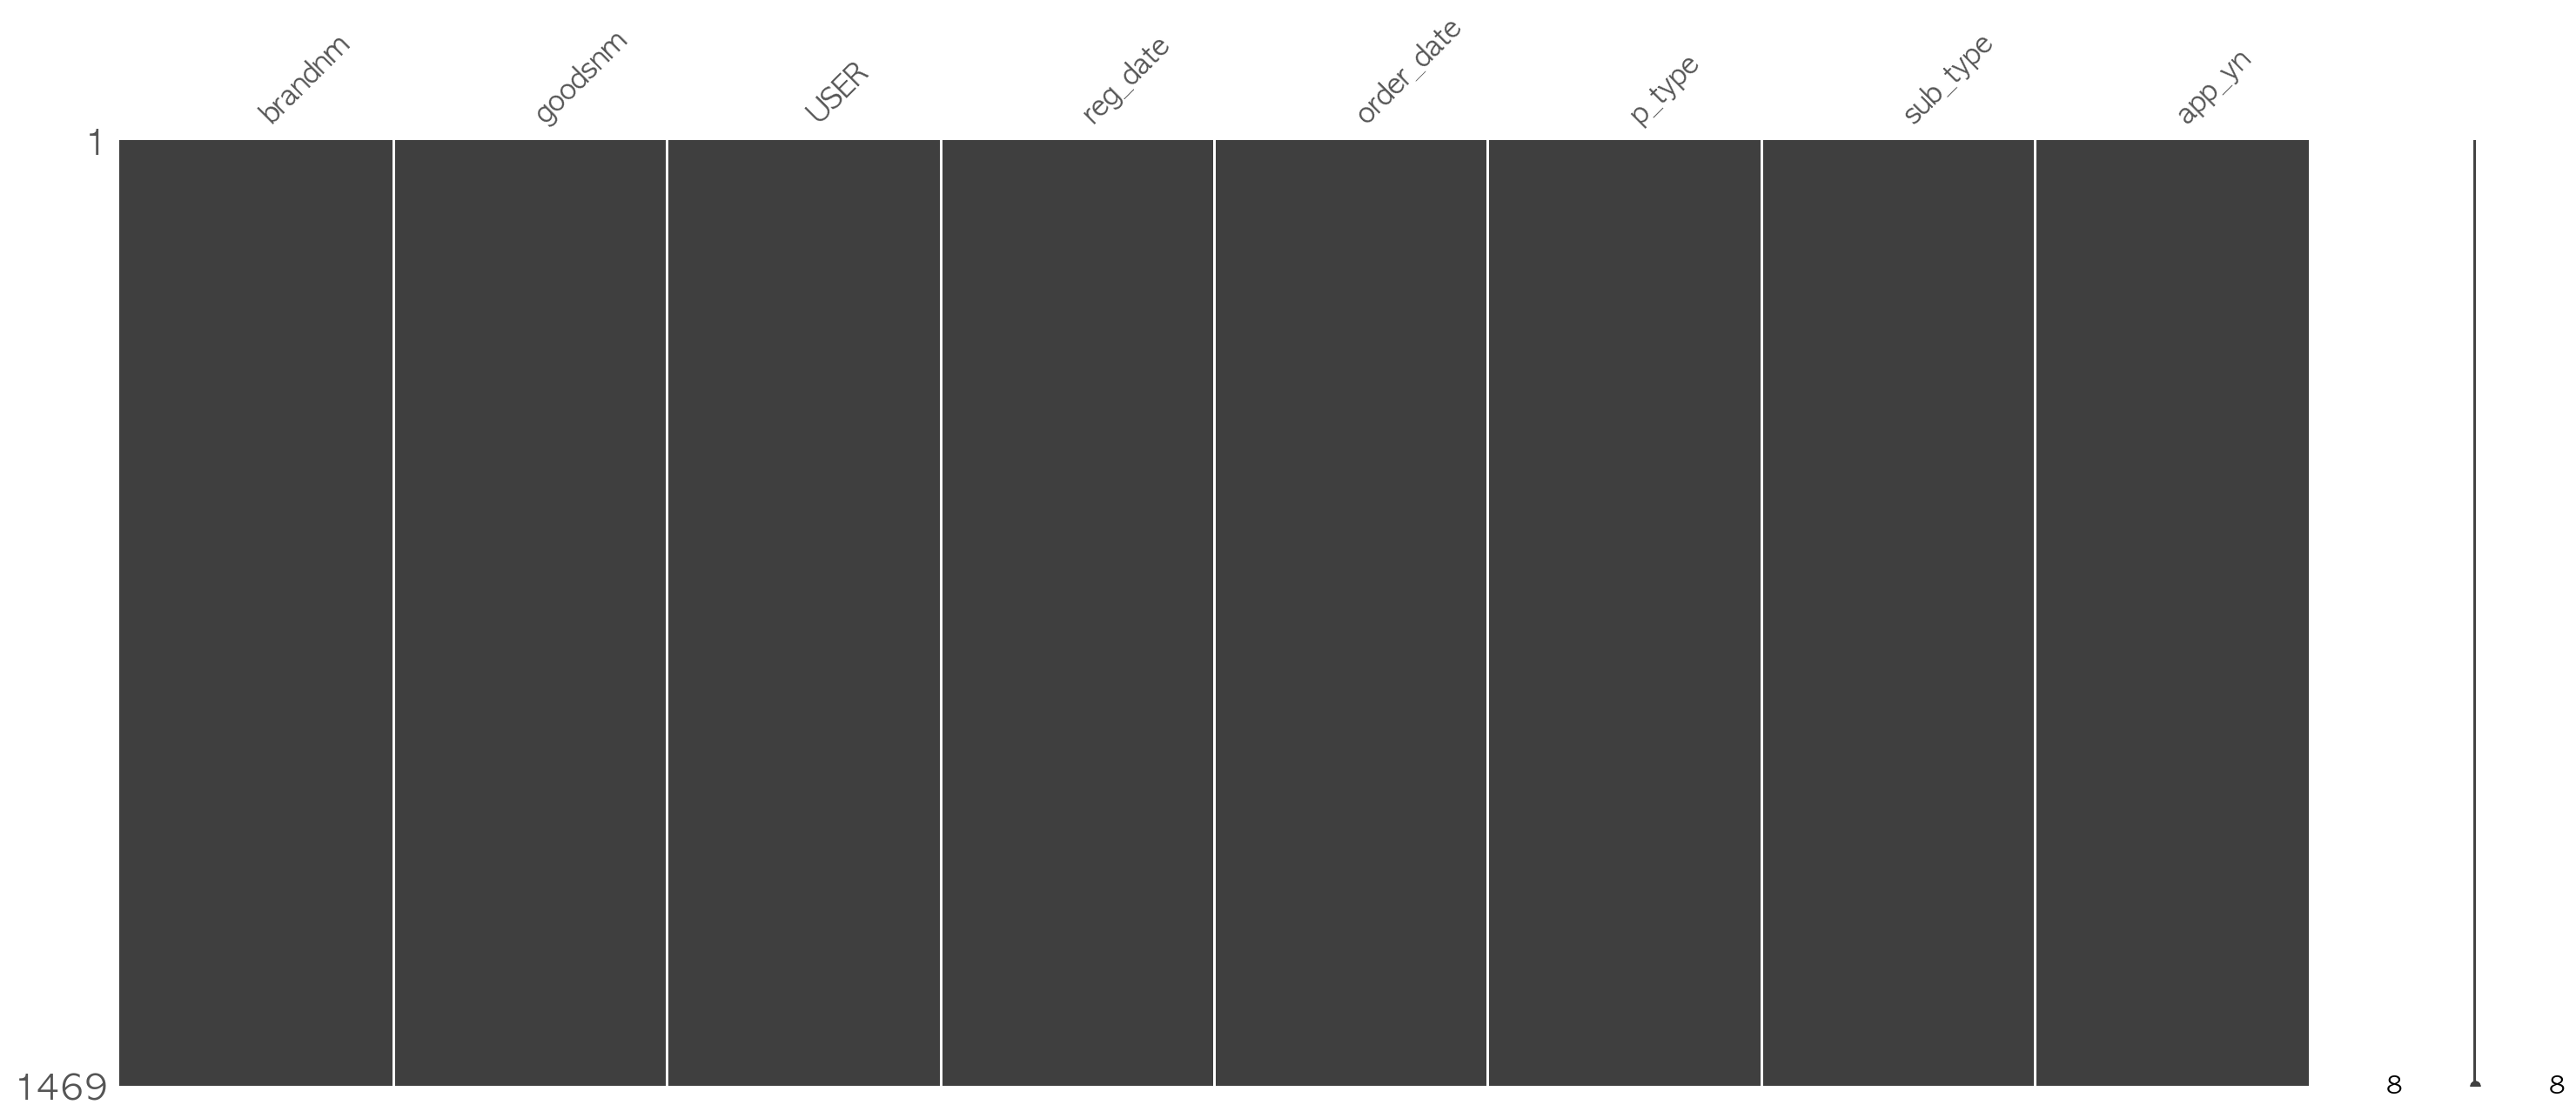

In [5]:
msno.matrix(df)

# 주문 아이템 분석

### EDA를 통해 데이터 살펴보기
* 1. 구매 소요 시간 분석
*  1-1. 가입일, 구매일의 경과일을 살펴보기
* 2. 구매 상품 트렌드 분석
*  2-1. 유저당 주문 수량 분석
*  2-2. 주문 아이템 분석

### 구매 소요 시간 주 단위로 살펴보기

In [6]:
# 당월 n주차 구해보기
# 가입날짜부터 주차별로 나열하기
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['order_date'] = pd.to_datetime(df['order_date'])
df['reg_date_ym']=df['reg_date'].dt.strftime('%y-%m')
df['reg_date_w']='NaN'

#당월 n주차 구하는 함수 
def week_of_month(dt):

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

#당월 n주차 구하기
for idx, (y, m, n) in enumerate(zip(df.reg_date.dt.year, df.reg_date.dt.month, df.reg_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    df['reg_date_w'][idx]= temp_week

df['reg_date_ymw']=df.reg_date_ym+'-'+df.reg_date_w.astype(str)

In [7]:
# 주문 날짜도 주차별로 보기
df['order_date_ym']=df['order_date'].dt.strftime('%y-%m')
df['order_date_w']=0
for idx, (y, m, n) in enumerate(zip(df.order_date.dt.year, df.order_date.dt.month, df.order_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    df['order_date_w'][idx]= temp_week

df['order_date_ymw']=df.order_date_ym+'-'+df.order_date_w.astype(str)

In [8]:
# 필요없는 column 드랍
drop_cols=['reg_date_ym','reg_date_w','order_date_w','order_date_ym','order_date_w','reg_date_w']

data = df.drop(drop_cols, 1)

In [9]:
# 주차별 주문 수 확인

order = data.groupby('order_date_ymw').count()['USER'].reset_index()

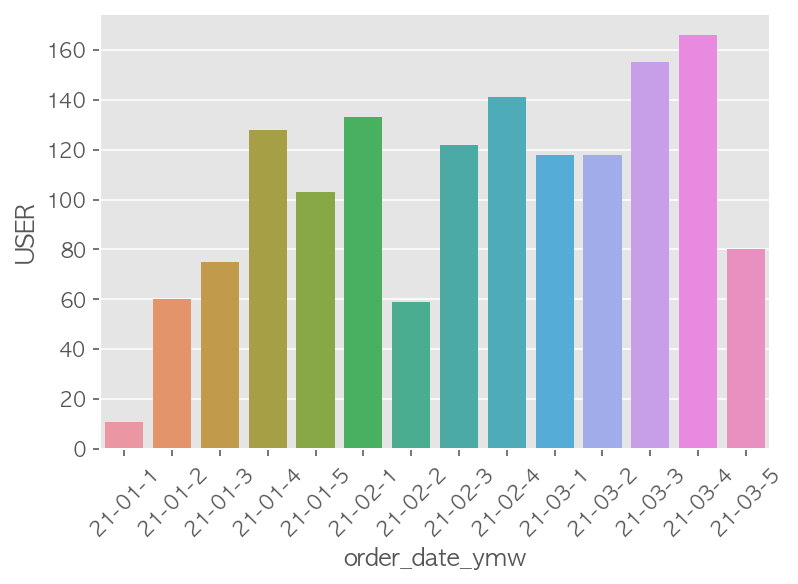

In [10]:
sns.barplot(data=order, x='order_date_ymw', y='USER')
plt.xticks(rotation = 45)
plt.show()

### 월별로도 확인

In [11]:
month_list = [
    (data['order_date'] <='2021-01-31'),
    (data['order_date'] <='2021-02-28') & (data['order_date'] >'2021-01-31'),
    (data['order_date'] <='2021-03-31') & (data['order_date'] >'2021-02-28')]

indi_list = ['1월구매자', '2월구매자', '3월구매자']

data['월별구매자'] = np.select(month_list, indi_list)

In [12]:
buyer_type = data.groupby(['sub_type', '월별구매자']).count()['USER'].sort_values(ascending=False).reset_index()
buyer_type

sub_type  월별구매자  USER
0        BA  3월구매자   310
1        BA  2월구매자   234
2        BA  1월구매자   148
3         D  3월구매자   128
4         O  2월구매자    97
5         O  3월구매자    87
6         O  1월구매자    83
7         D  2월구매자    69
8         T  3월구매자    65
9         D  1월구매자    64
10        T  1월구매자    60
11        T  2월구매자    39
12        B  3월구매자    38
13       TP  1월구매자    11
14        B  1월구매자    11
15        B  2월구매자     9
16       TP  3월구매자     9
17       TP  2월구매자     7

### 월별로 구매가 늘어나며 가방과 드레스의 렌탈 상승이 보임

<AxesSubplot:xlabel='sub_type', ylabel='USER'>

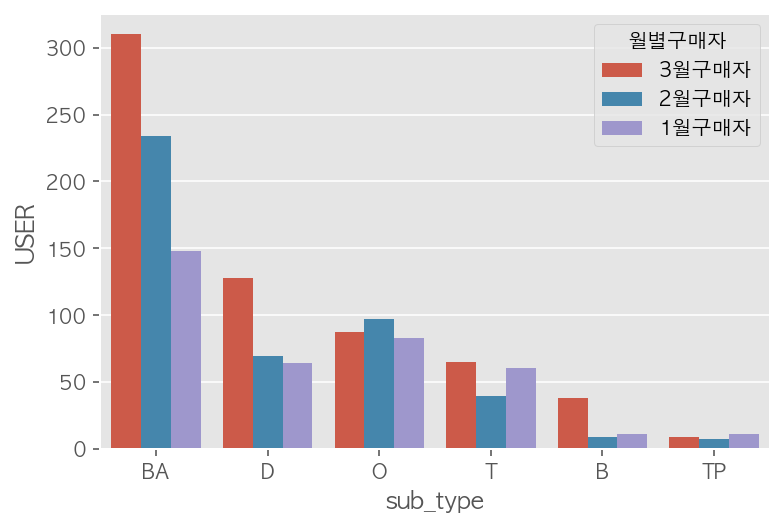

In [13]:
sns.barplot(data = buyer_type, x='sub_type', y='USER', hue='월별구매자')

# 주문 아이템 분석
- 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
- 신규 유저들의 구매 트렌드 파악

## 브랜드 별 선호도 분석

In [14]:
print("브랜드 갯수 총",str(len(df['brandnm'].unique())),"개")

브랜드 갯수 총 258 개


In [15]:
df['brandnm'].unique()

array(['Gucci', 'El estilo de Claire', 'Danha', 'Burberry London',
       'Prada', 'Max Mara', 'Molliolli', 'Sandro', 'Louis Vuitton',
       'Tory Burch', 'Chloe', 'Time', 'The Izzat', 'Mojosphine',
       'Ted Baker', '& Other Stories', 'Fendi', 'Balmain', 'Celine',
       'Burberry', 'Chanel', 'Dior', 'Bottega Veneta', 'Plastic Island',
       'Reneevon', 'Sorry Too Much Love', 'Saint Laurent', 'Miu Miu',
       'Yves Saint Laurent', 'Zooc', 'Vivienne Westwood',
       'Maison Kitsune', 'Margarin fingers', 'The Tint', 'Love Moschino',
       'Michaa', 'Vivienne Westwood Red Label', 'MSGM', 'Christian Dior',
       'It michaa', 'SJSJ', 'Amsale', 'Imvely', 'Chi Chi London', 'Maje',
       'Biker Starlet', 'Thom Browne', 'Jill By Jill Stuart',
       'Comme des Garcons', 'Nain', 'Dolce & Gabbana', 'Givenchy',
       'Salvatore Ferragamo', 'Andersen-Andersen', 'A.P.C.',
       'Self-portrait', 'Sonia Rykiel', 'Diane von Furstenberg',
       'Hugo Boss', 'Baum Und Pferdgarten', 'BCBG', '

In [16]:
df.groupby('brandnm').count()['USER'].describe()

count   258
mean      6
std      18
min       1
25%       1
50%       1
75%       3
max     232
Name: USER, dtype: float64

브랜드별로 구매한 갯수의 차이가 크다.

### 브랜드 인기 순위 top 20

In [17]:
top_20 = data.groupby(['brandnm', 'sub_type']).count()['USER'].sort_values(ascending=False)[:24].reset_index()
top_20

brandnm sub_type  USER
0                Gucci       BA   204
1        Saint Laurent       BA    84
2        Louis Vuitton       BA    77
3               Chanel       BA    75
4                Prada       BA    38
5   Yves Saint Laurent       BA    34
6             Burberry        O    30
7                Fendi       BA    23
8               Celine       BA    20
9             Max Mara        O    18
10              Sandro        D    17
11         Thom Browne        T    17
12               Prada        O    16
13      Christian Dior       BA    15
14               Gucci        T    14
15         Thom Browne        O    13
16              Chanel        O    13
17           It michaa        D    12
18               Chloe       BA    12
19               Gucci        D    11
20            Burberry       BA    10
21         Jill Stuart        D    10
22             Miu Miu       BA    10
23            Burberry        T    10

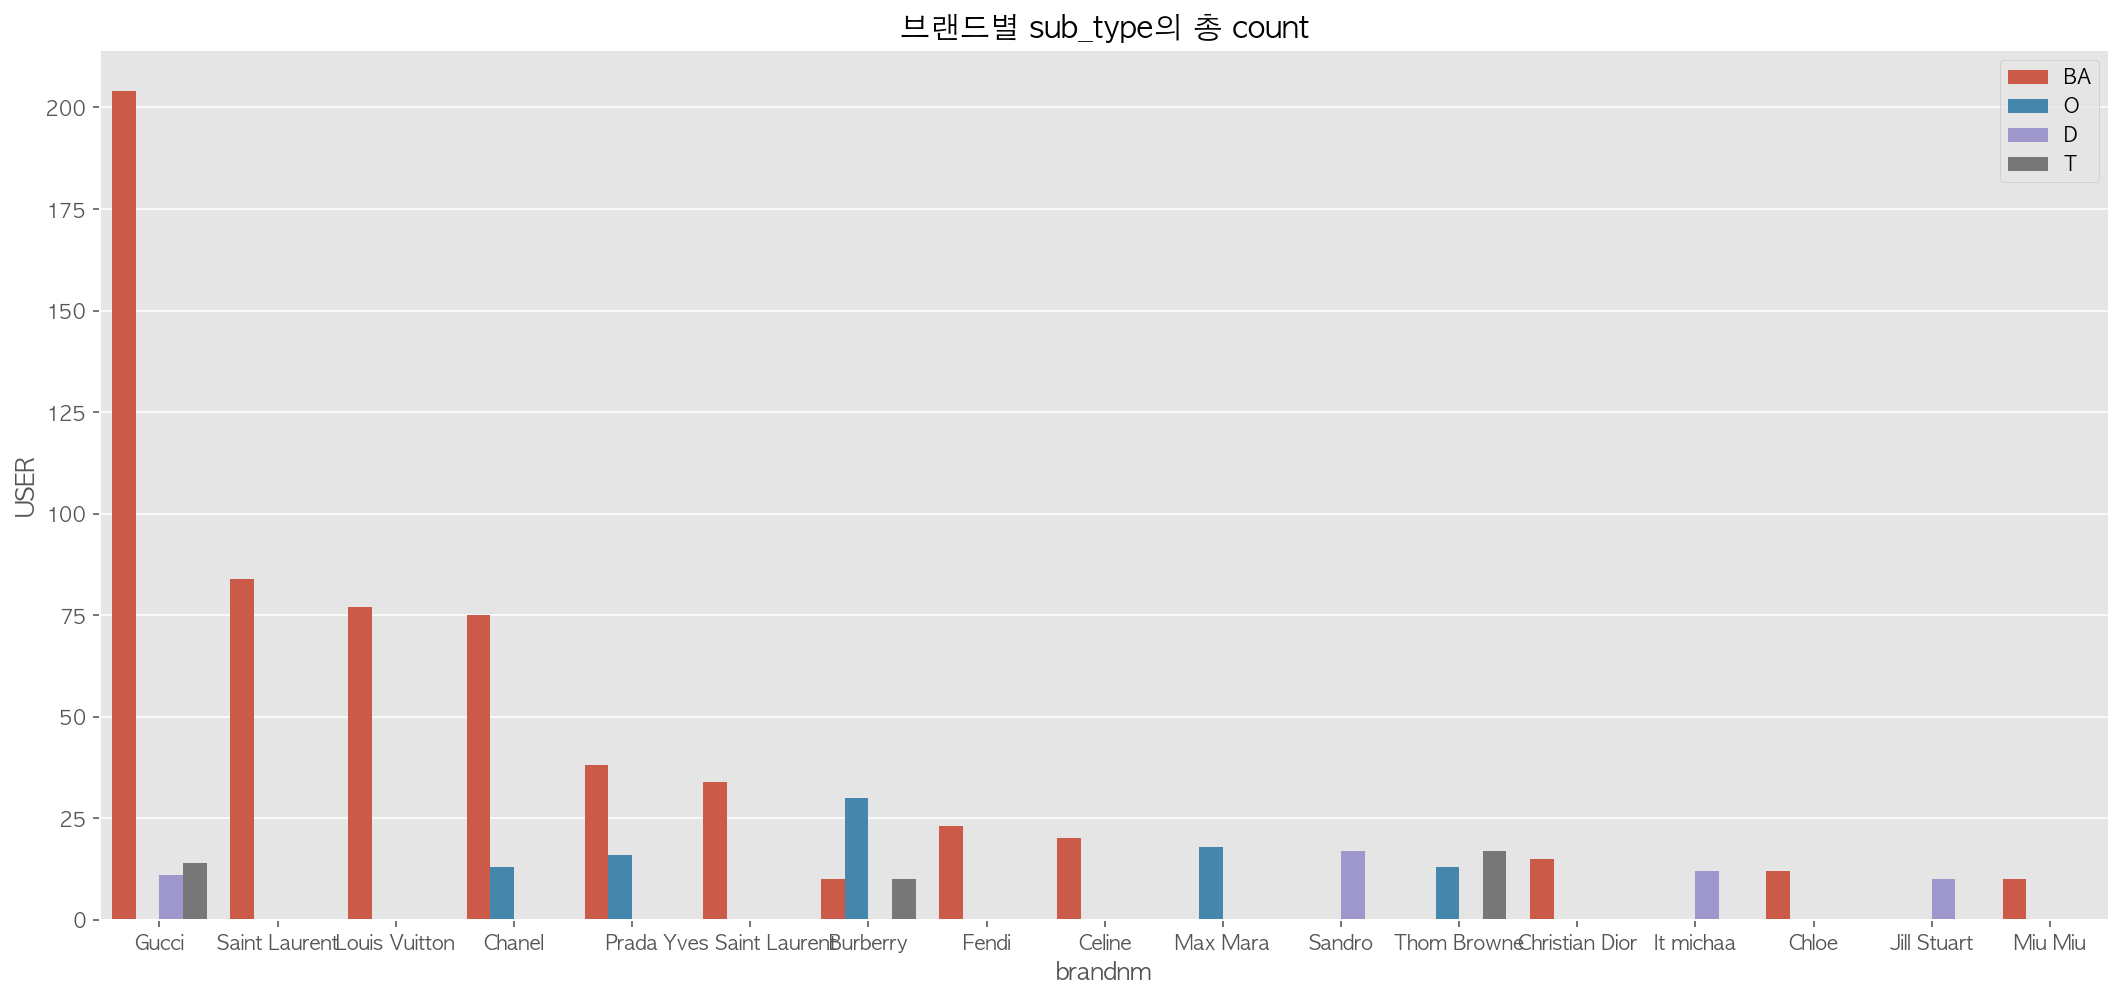

In [18]:
plt.figure(figsize=(18,8))

sns.barplot(data=top_20, x='brandnm', y='USER', hue='sub_type')

plt.title("브랜드별 sub_type의 총 count", fontsize = 15)
plt.legend(loc='upper right')

plt.show()

### 브랜드 인기 순위 top10

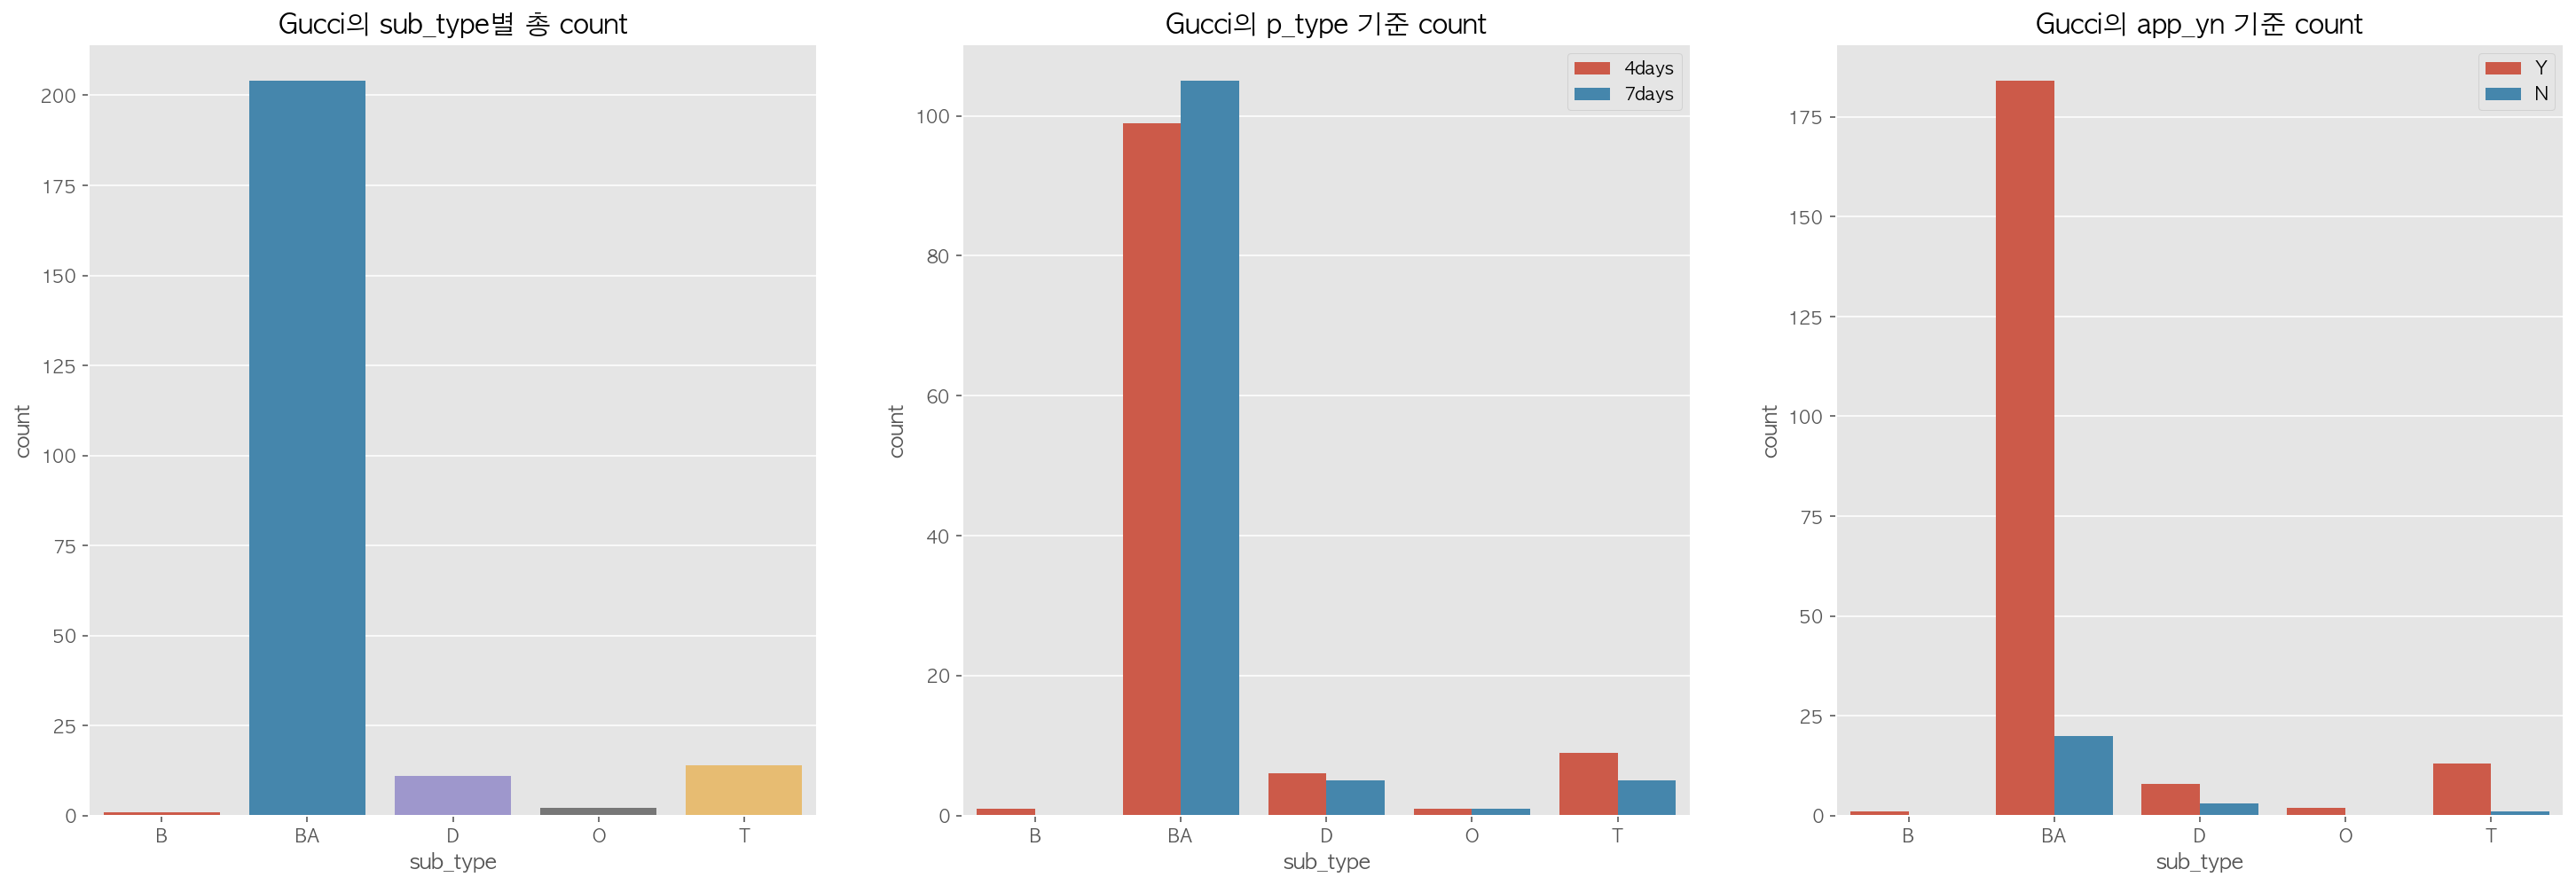

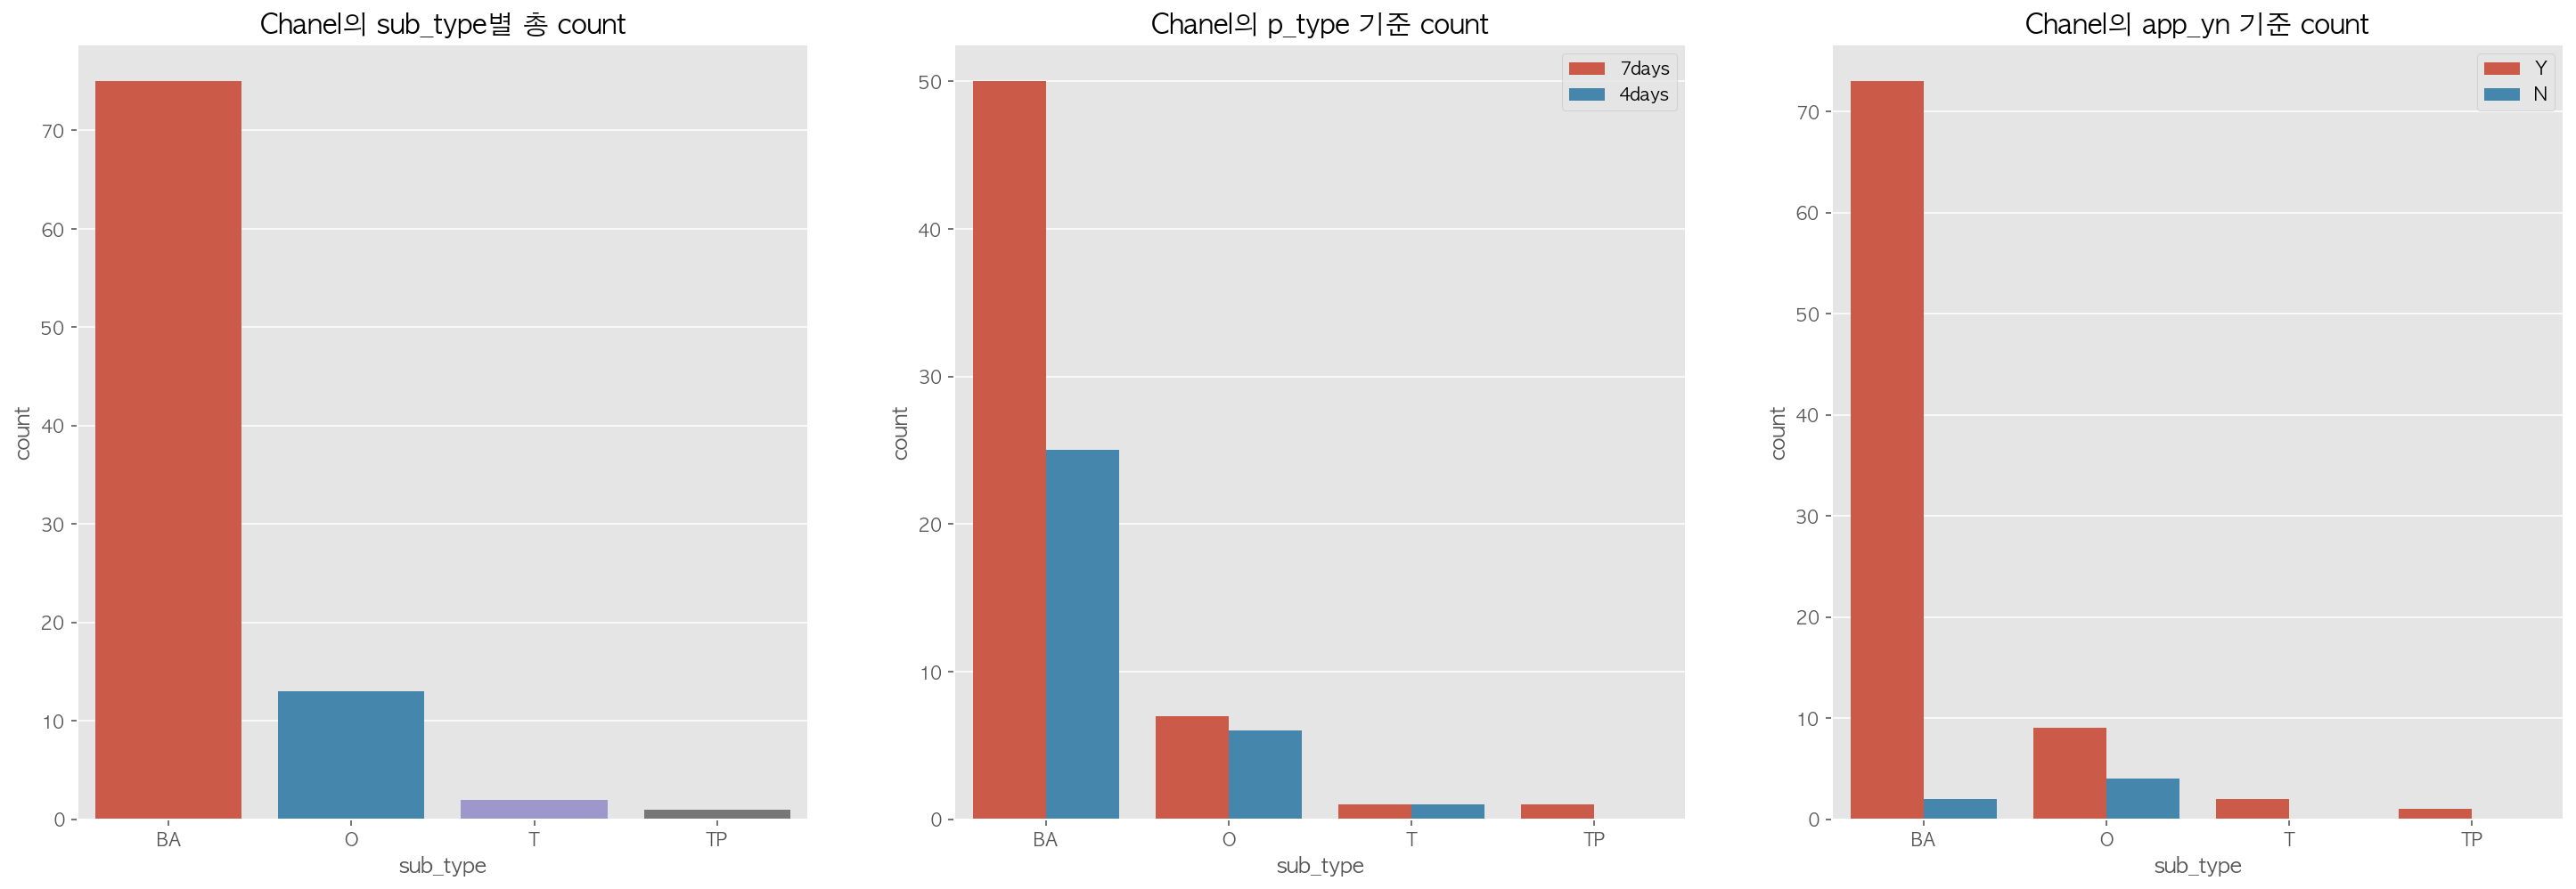

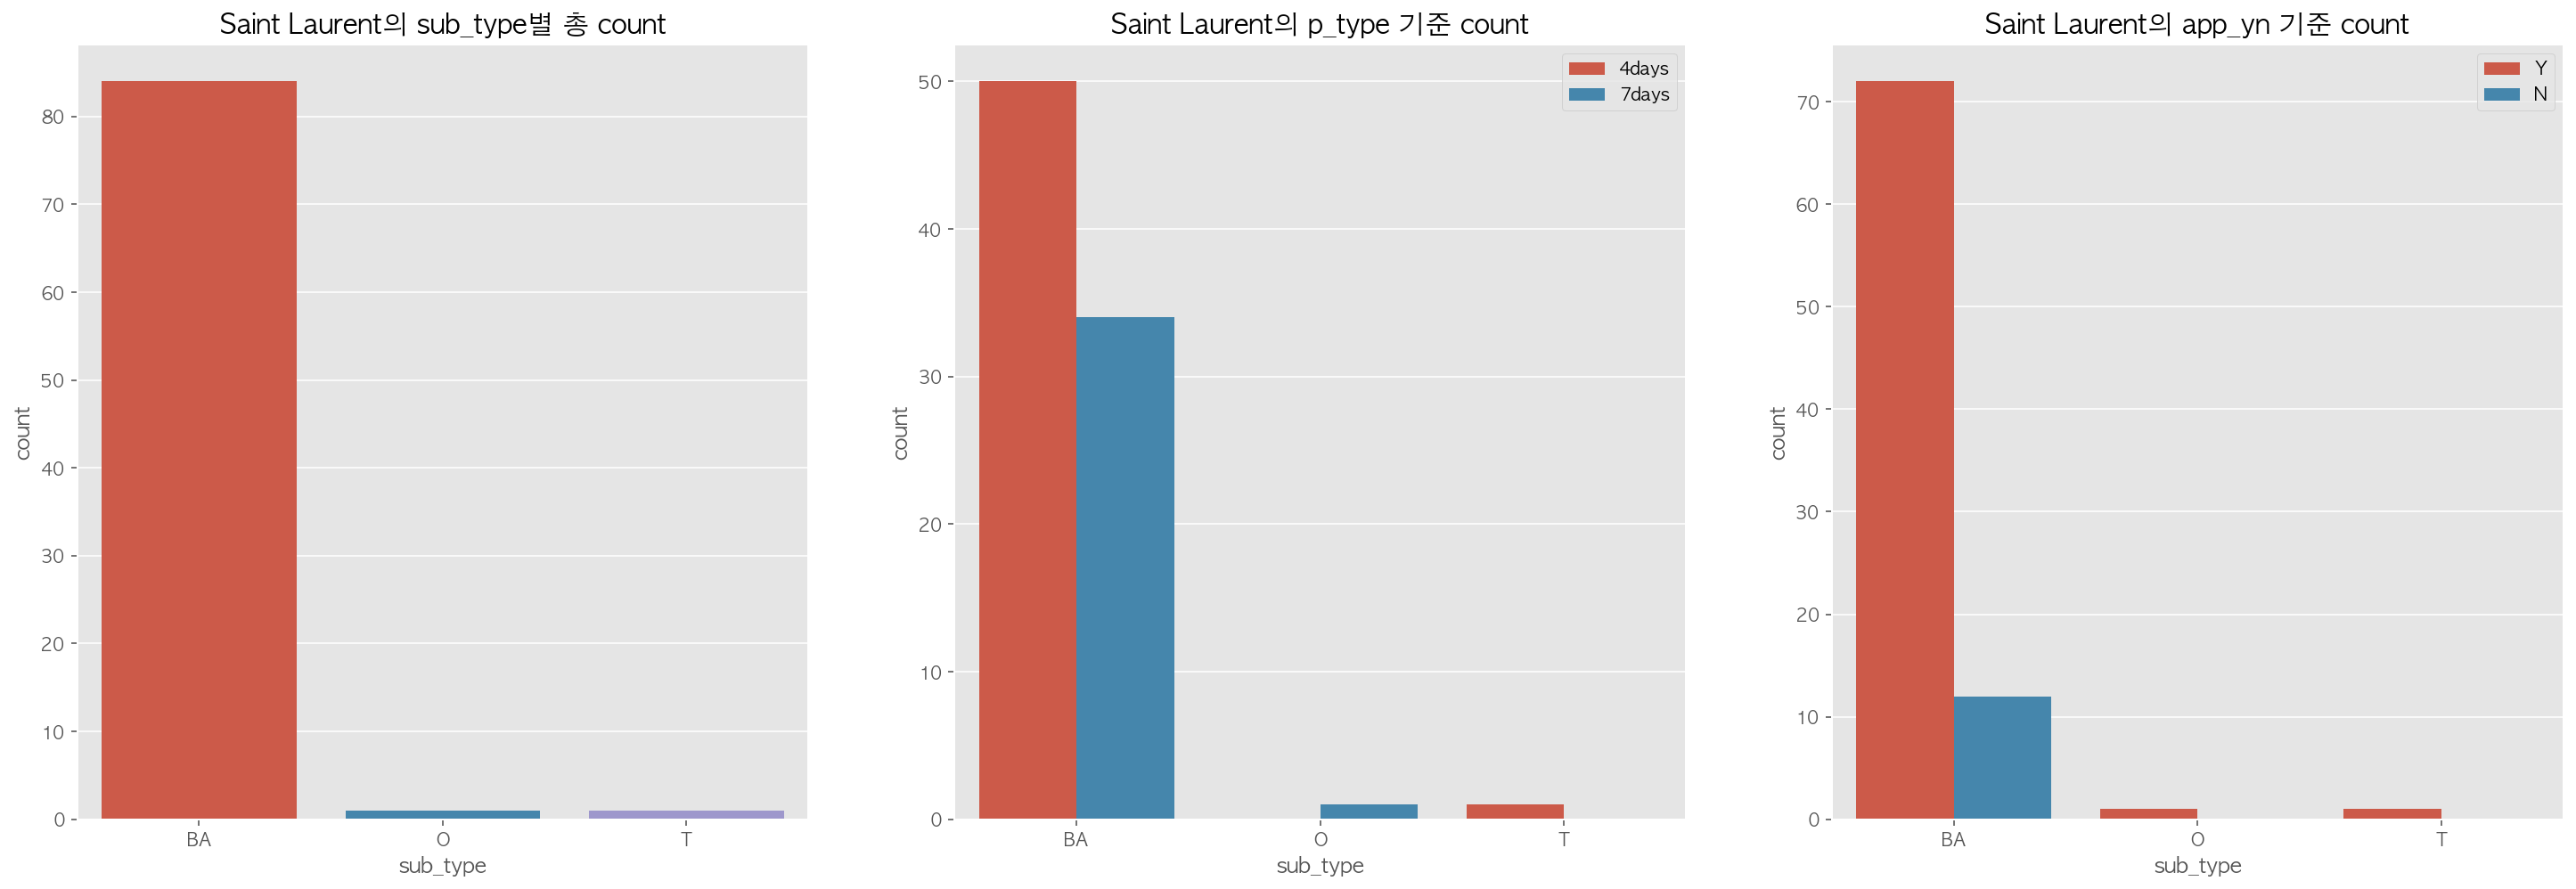

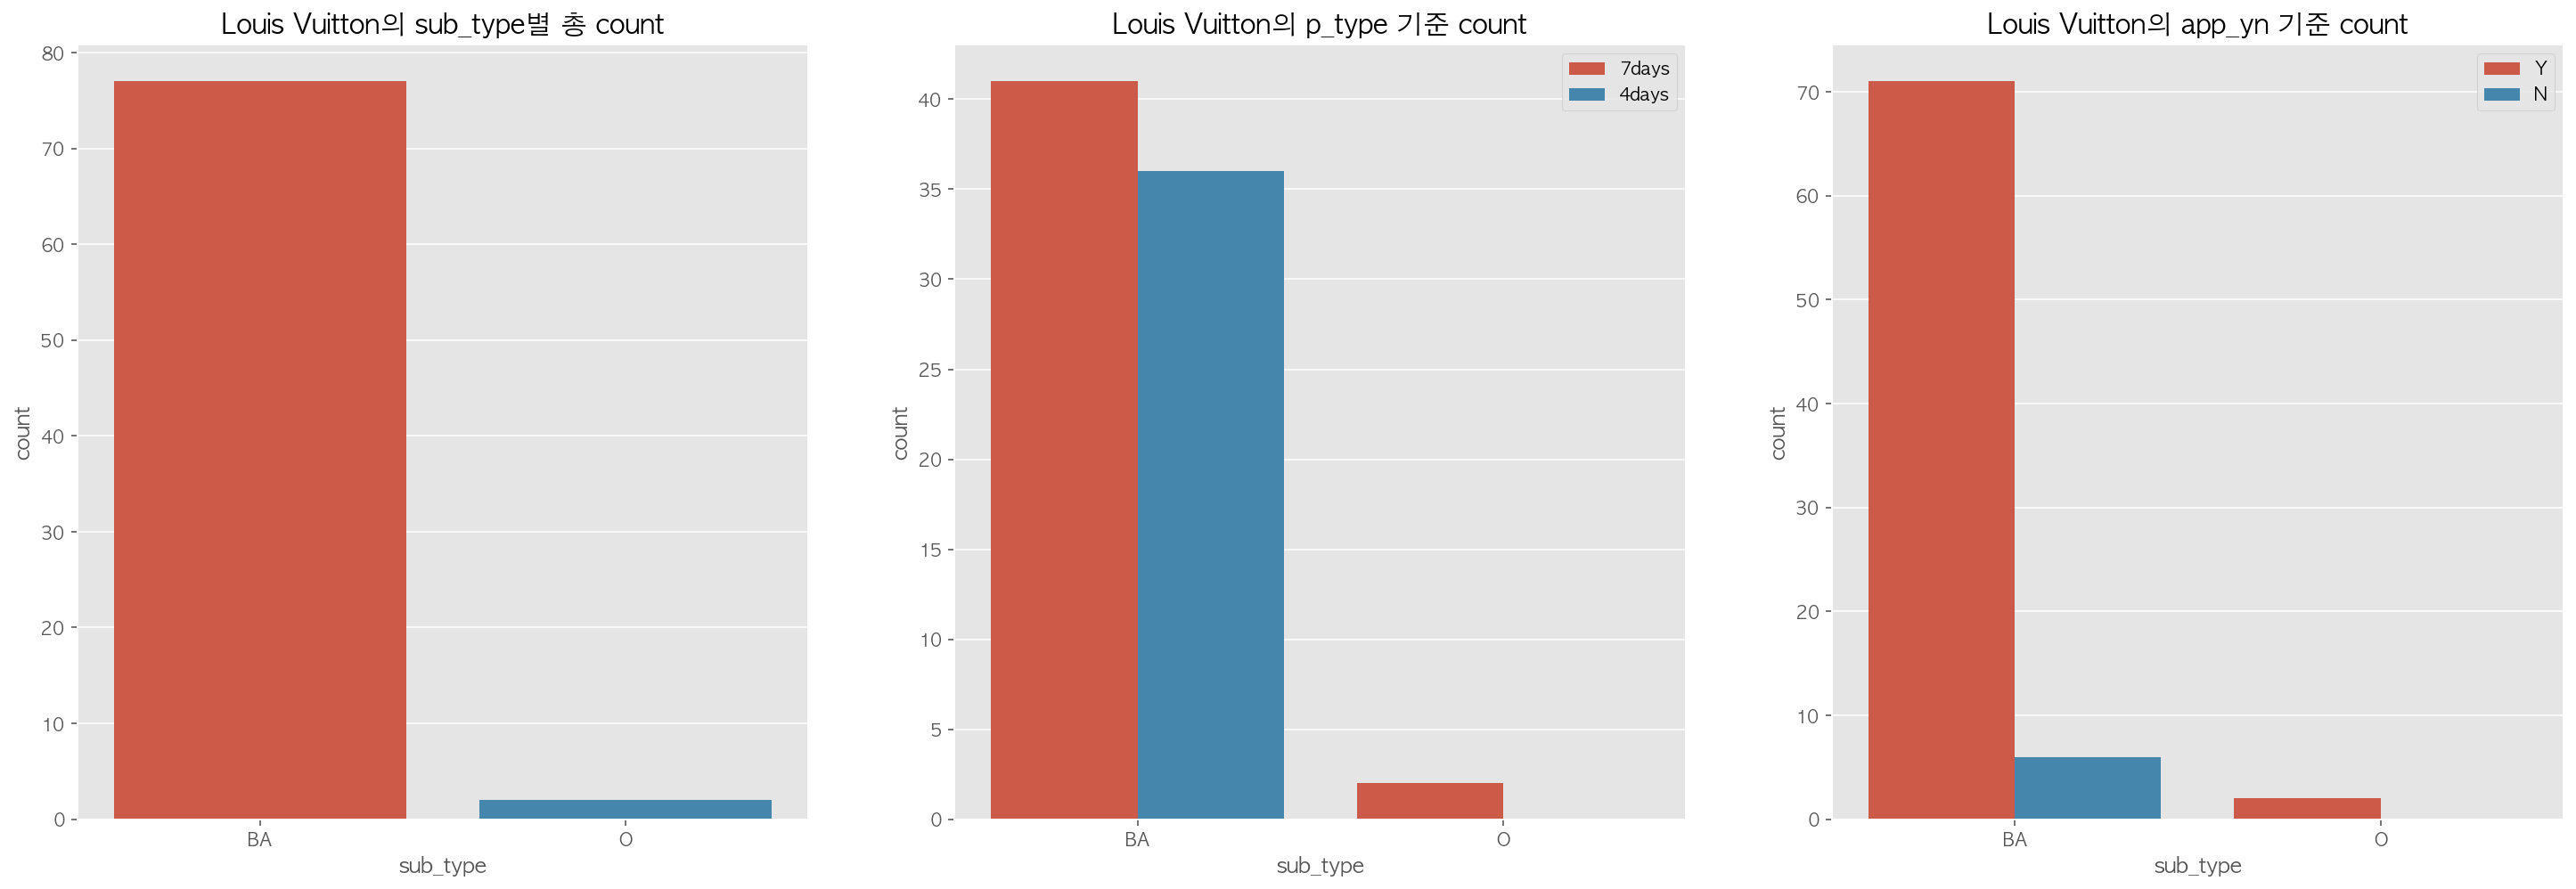

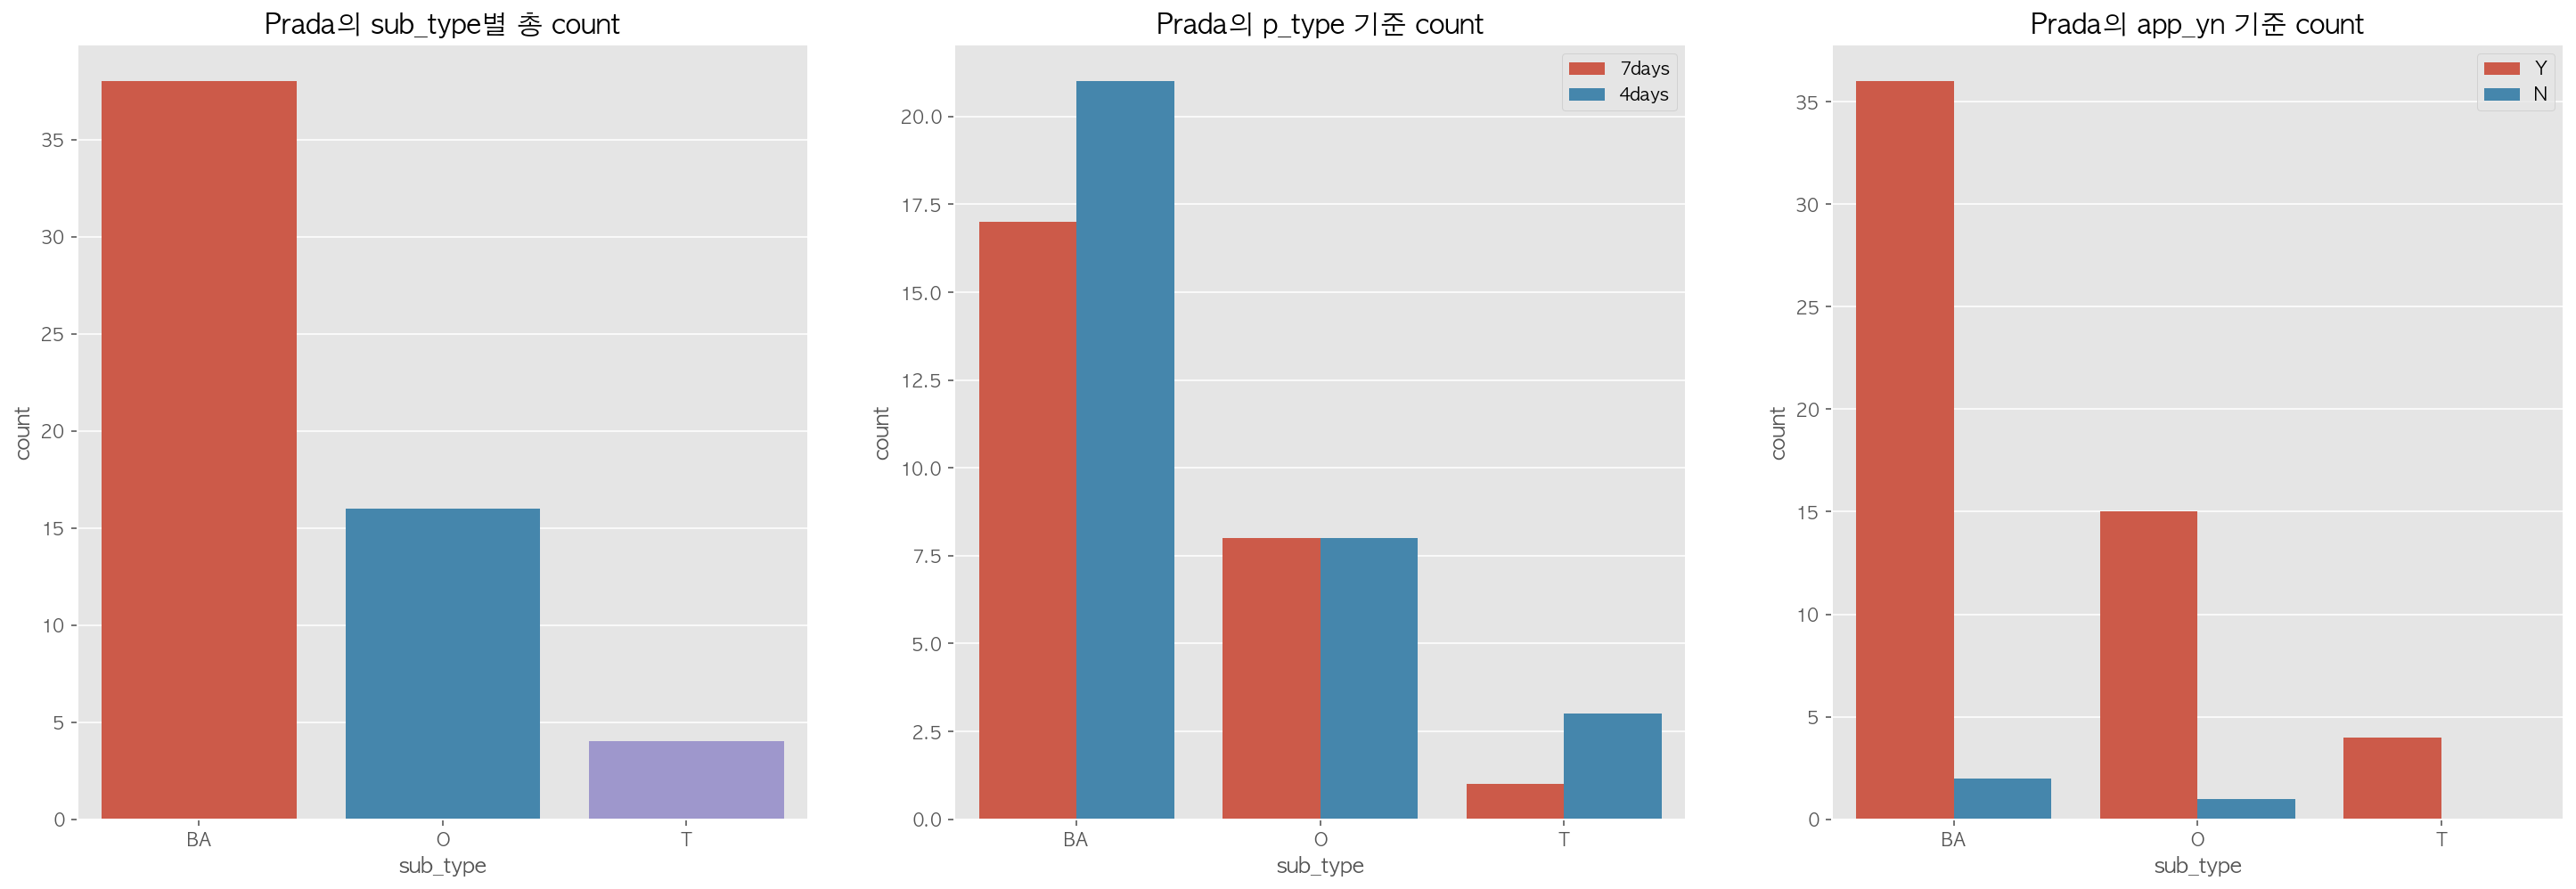

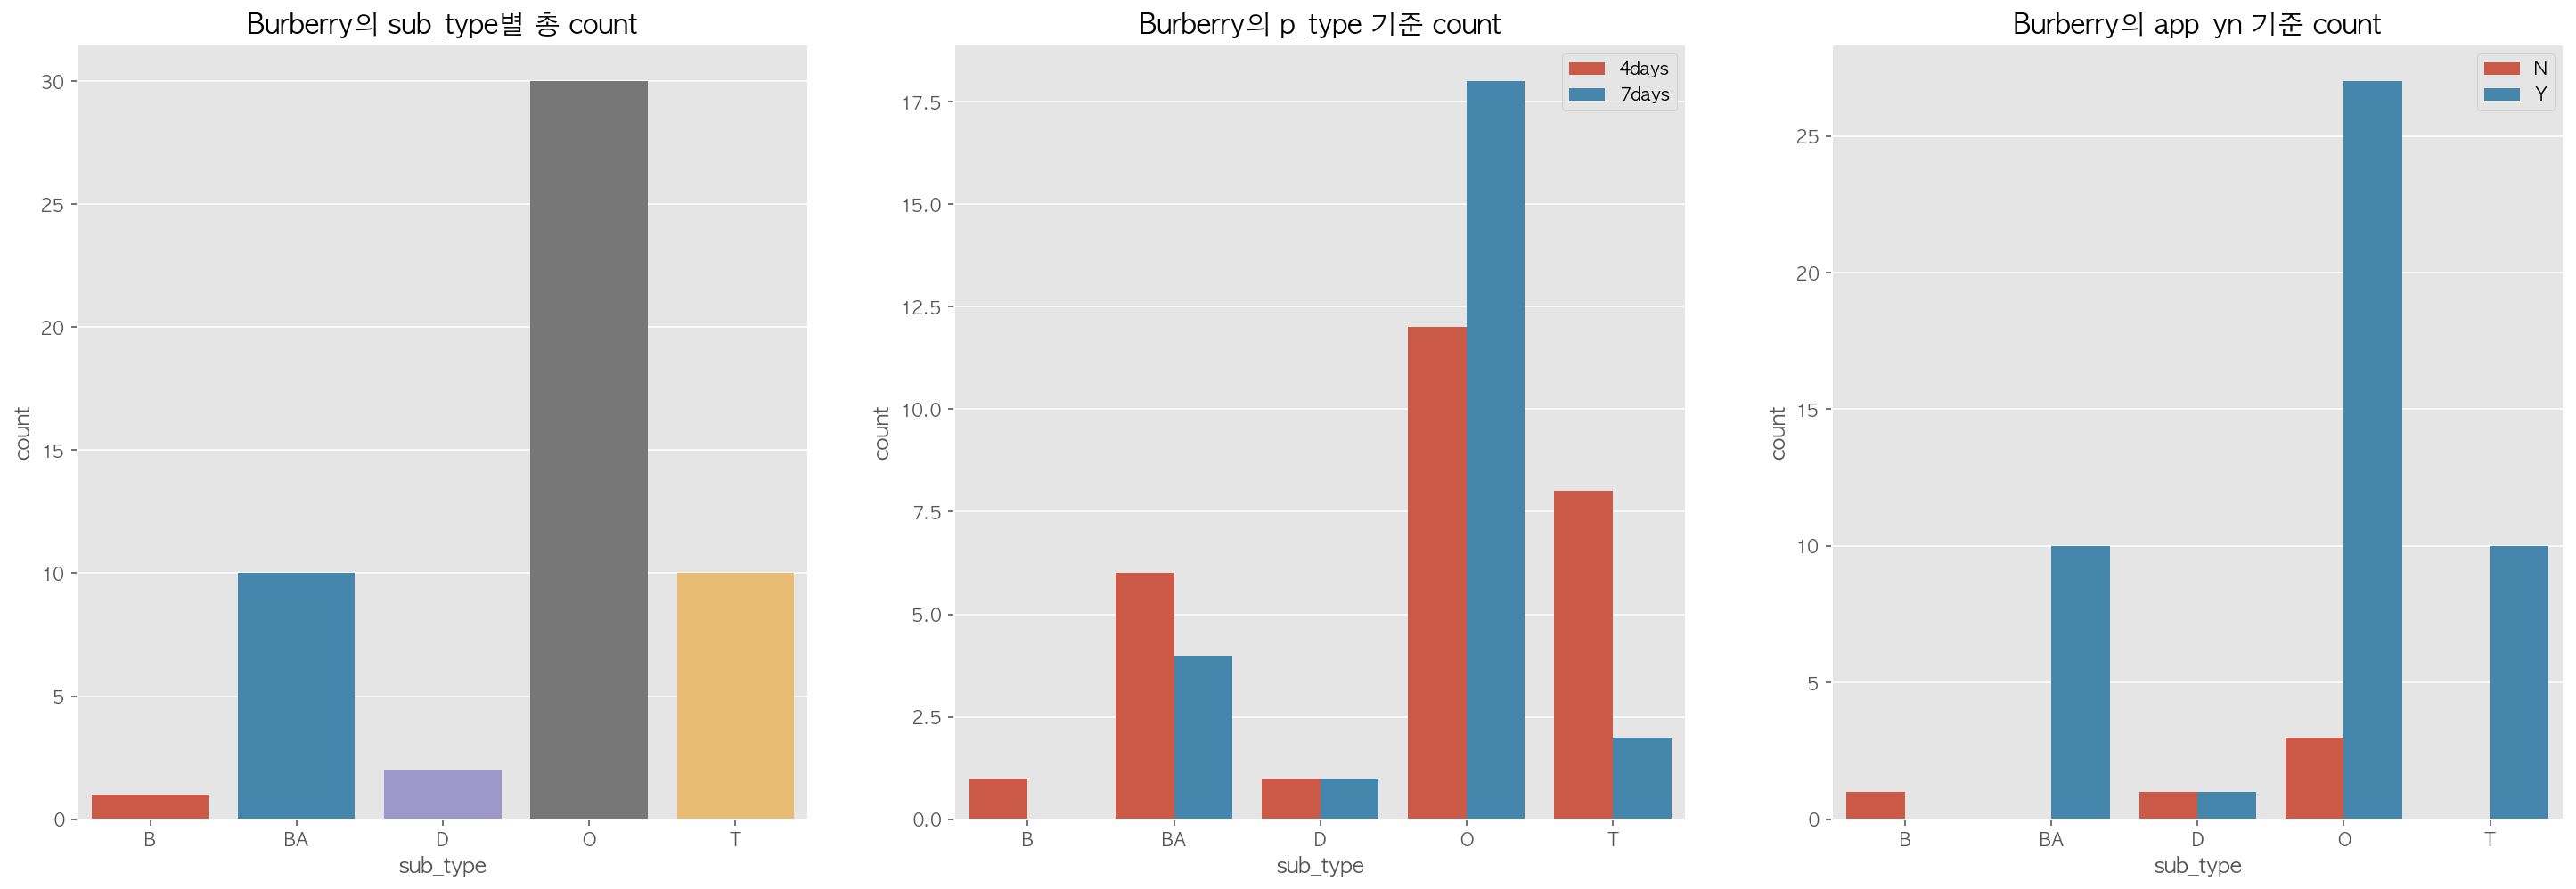

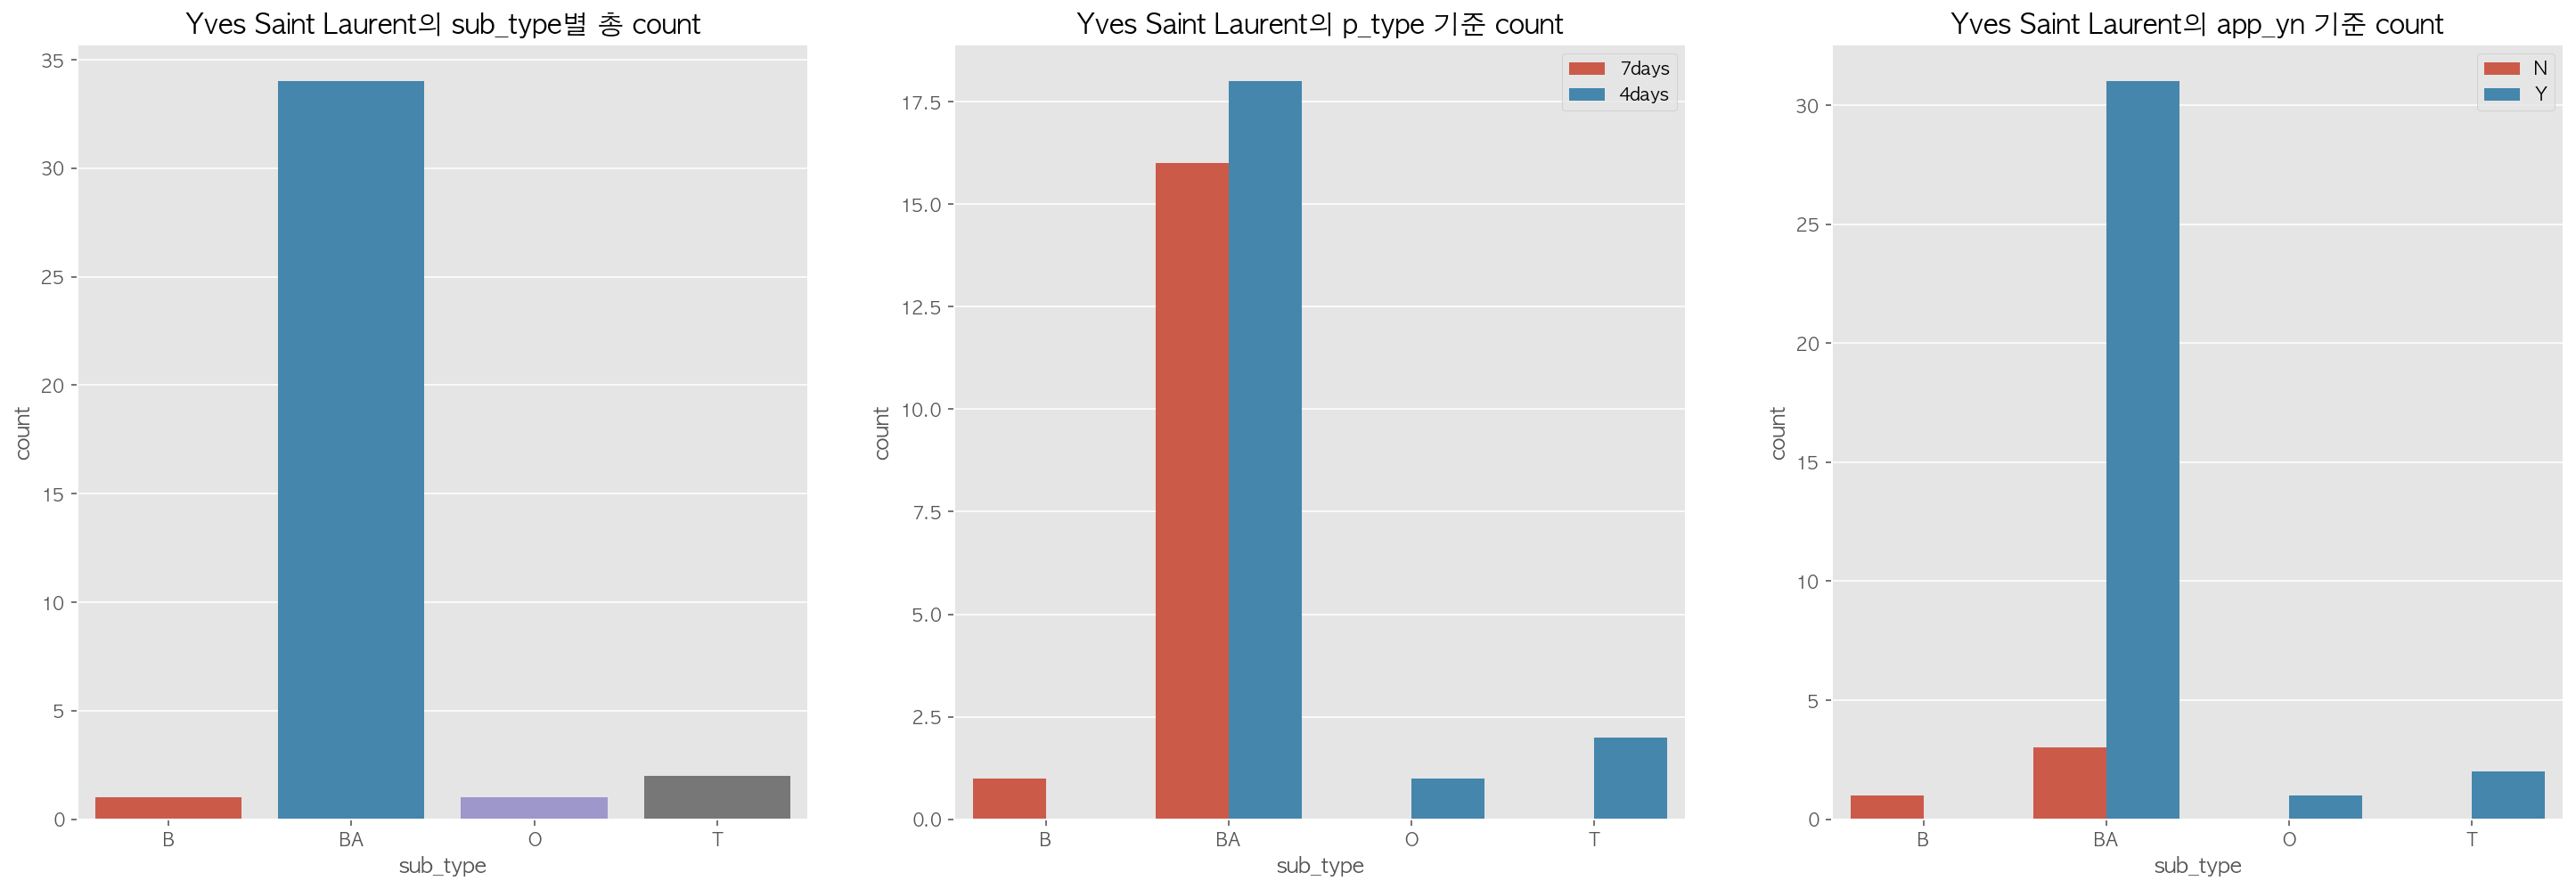

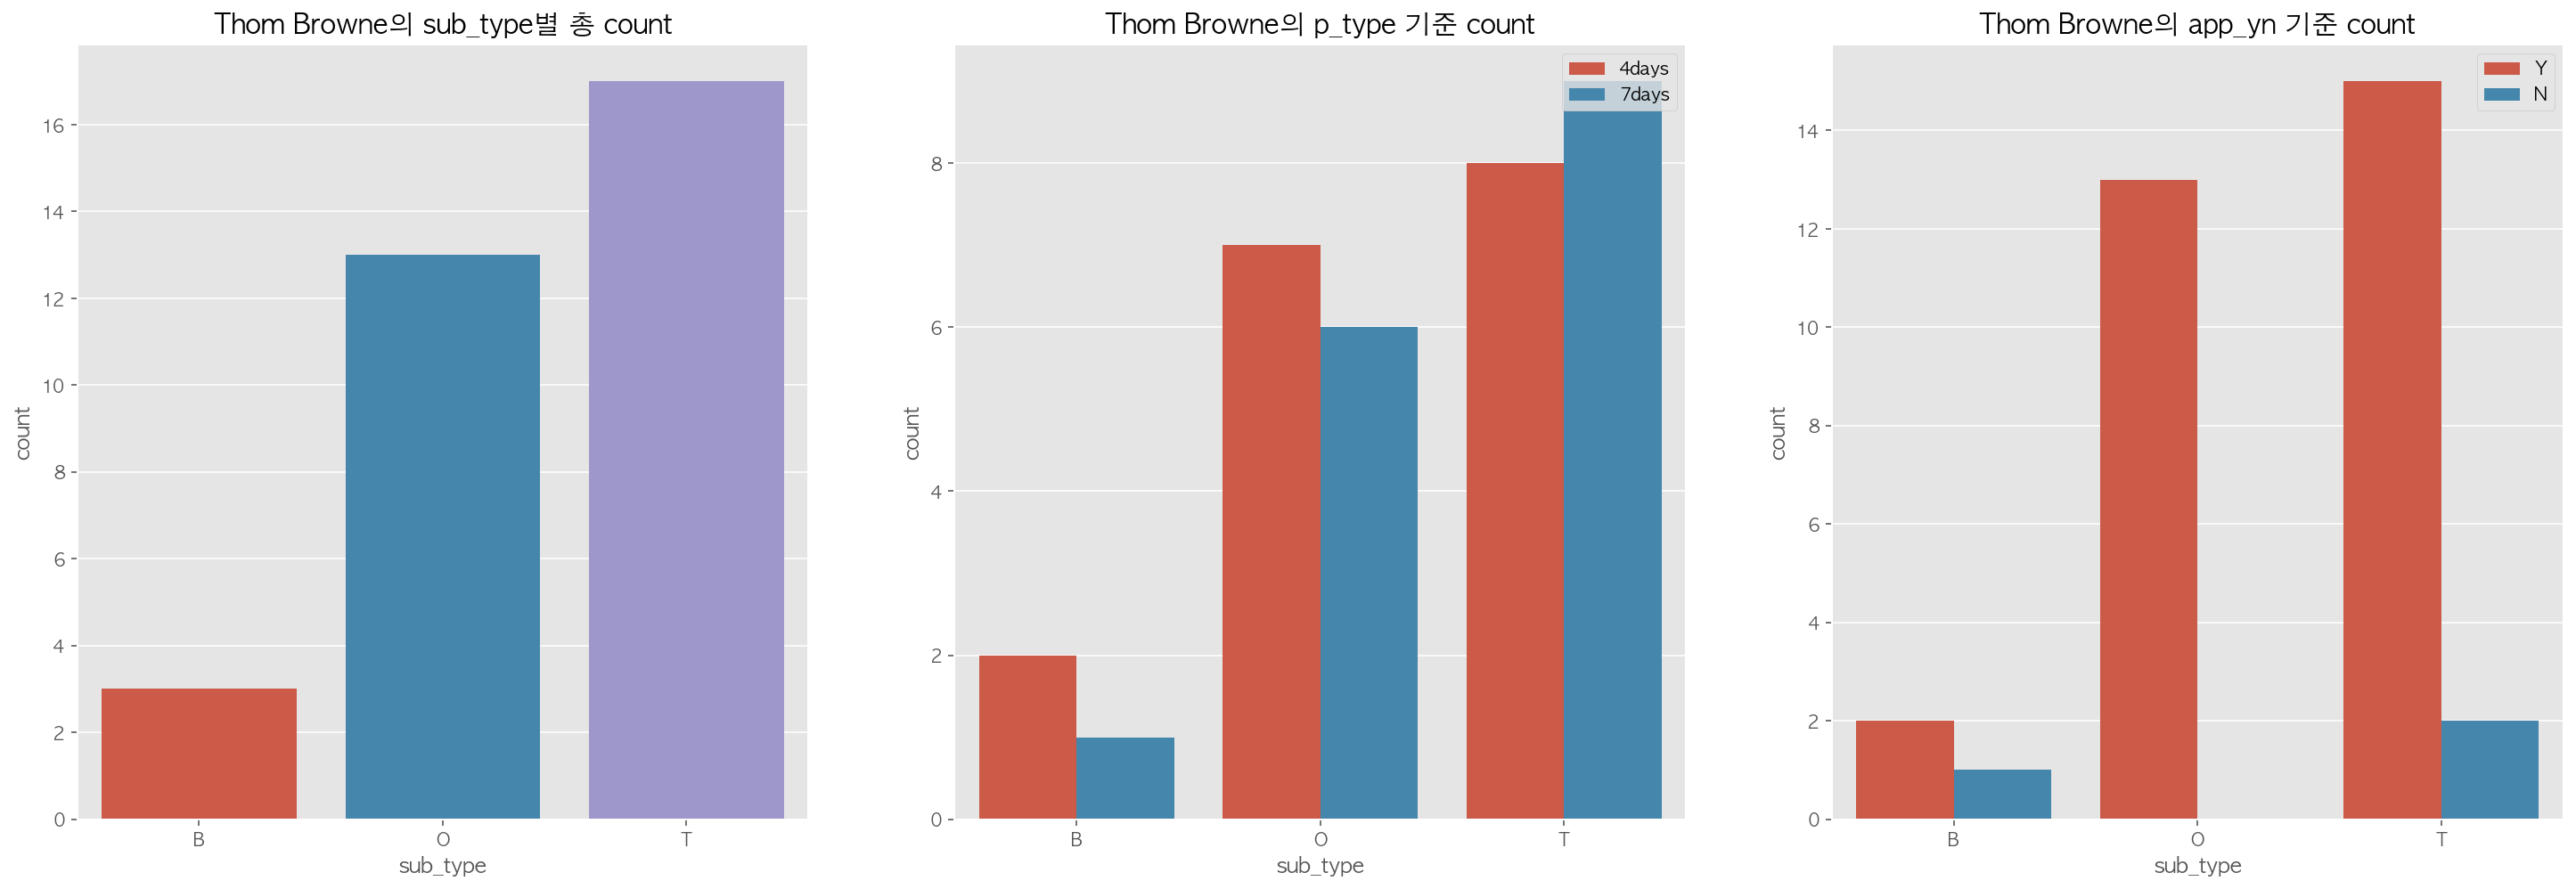

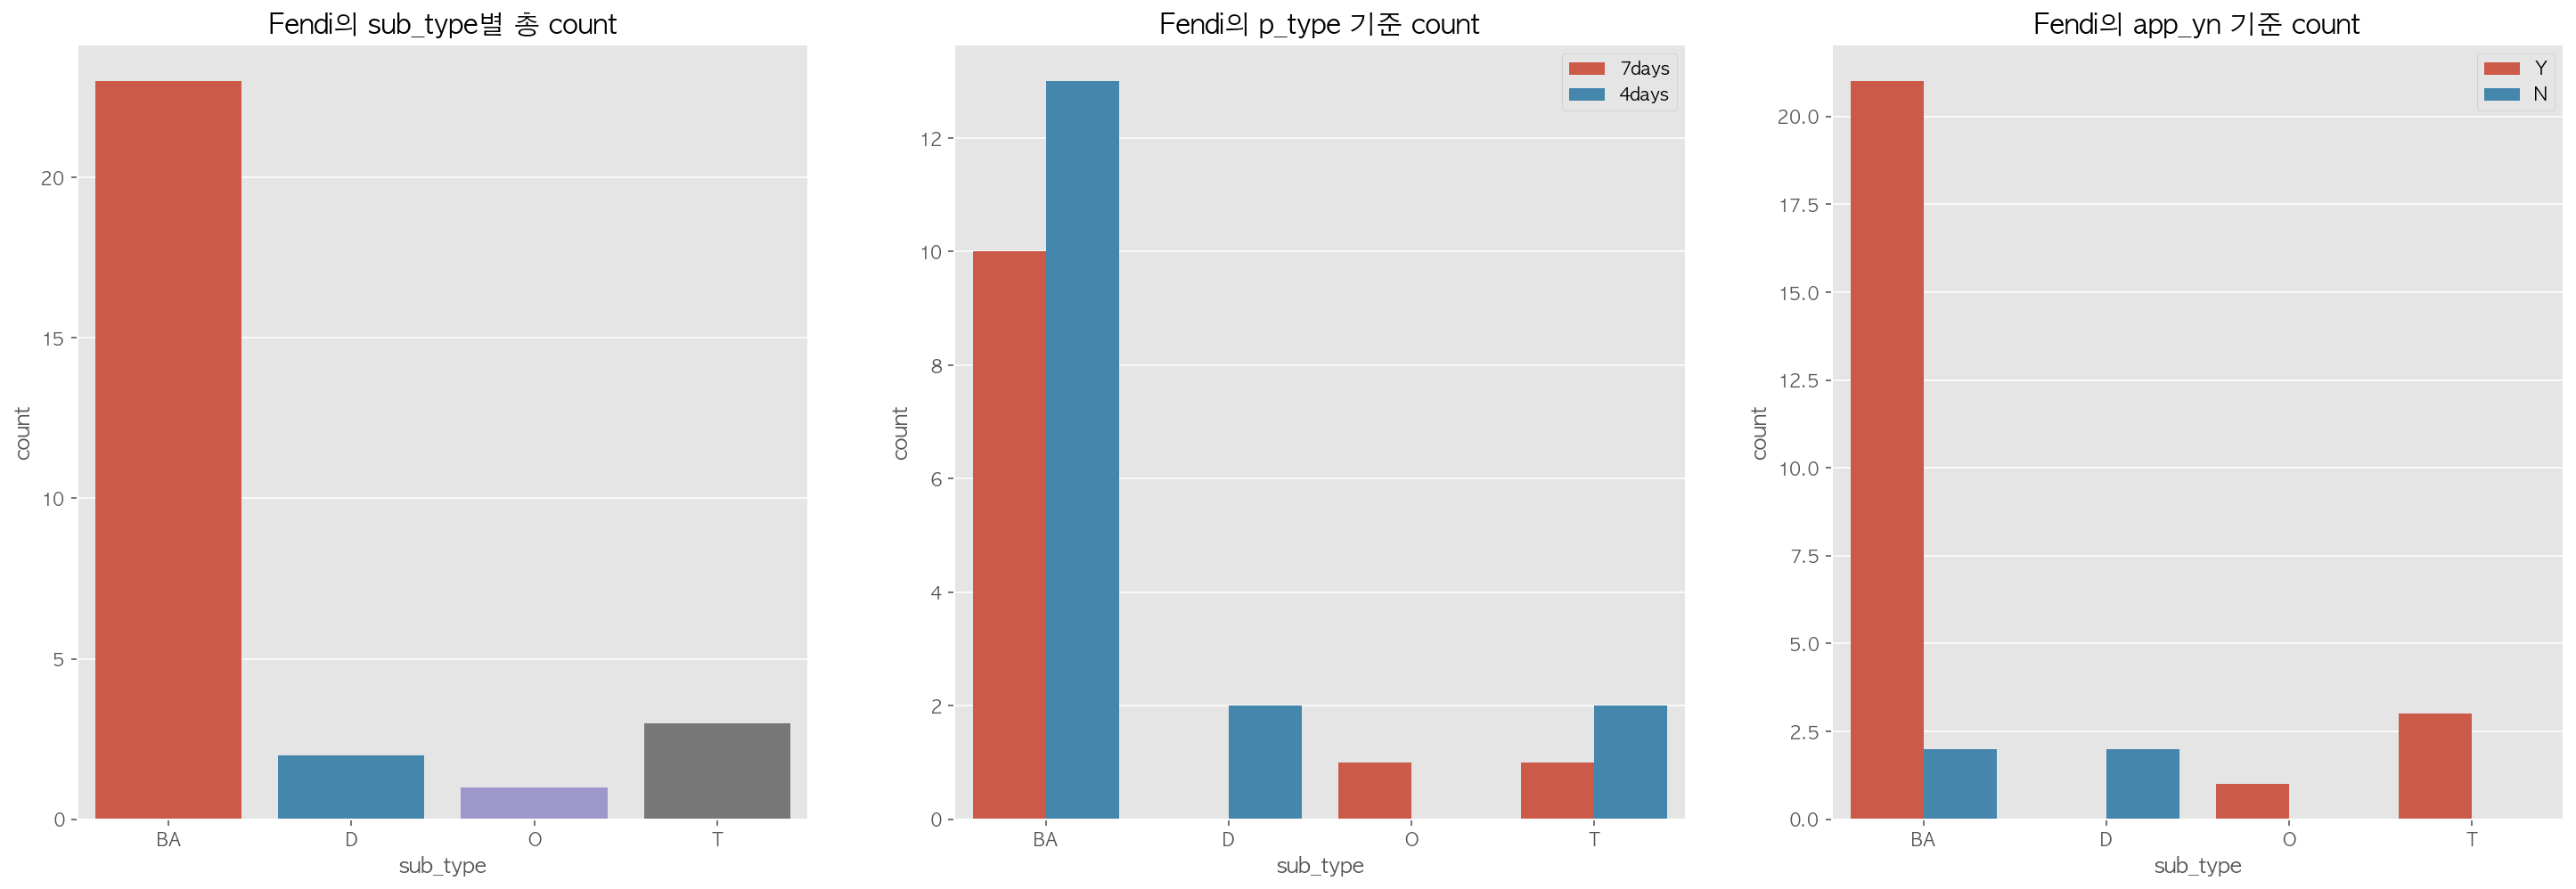

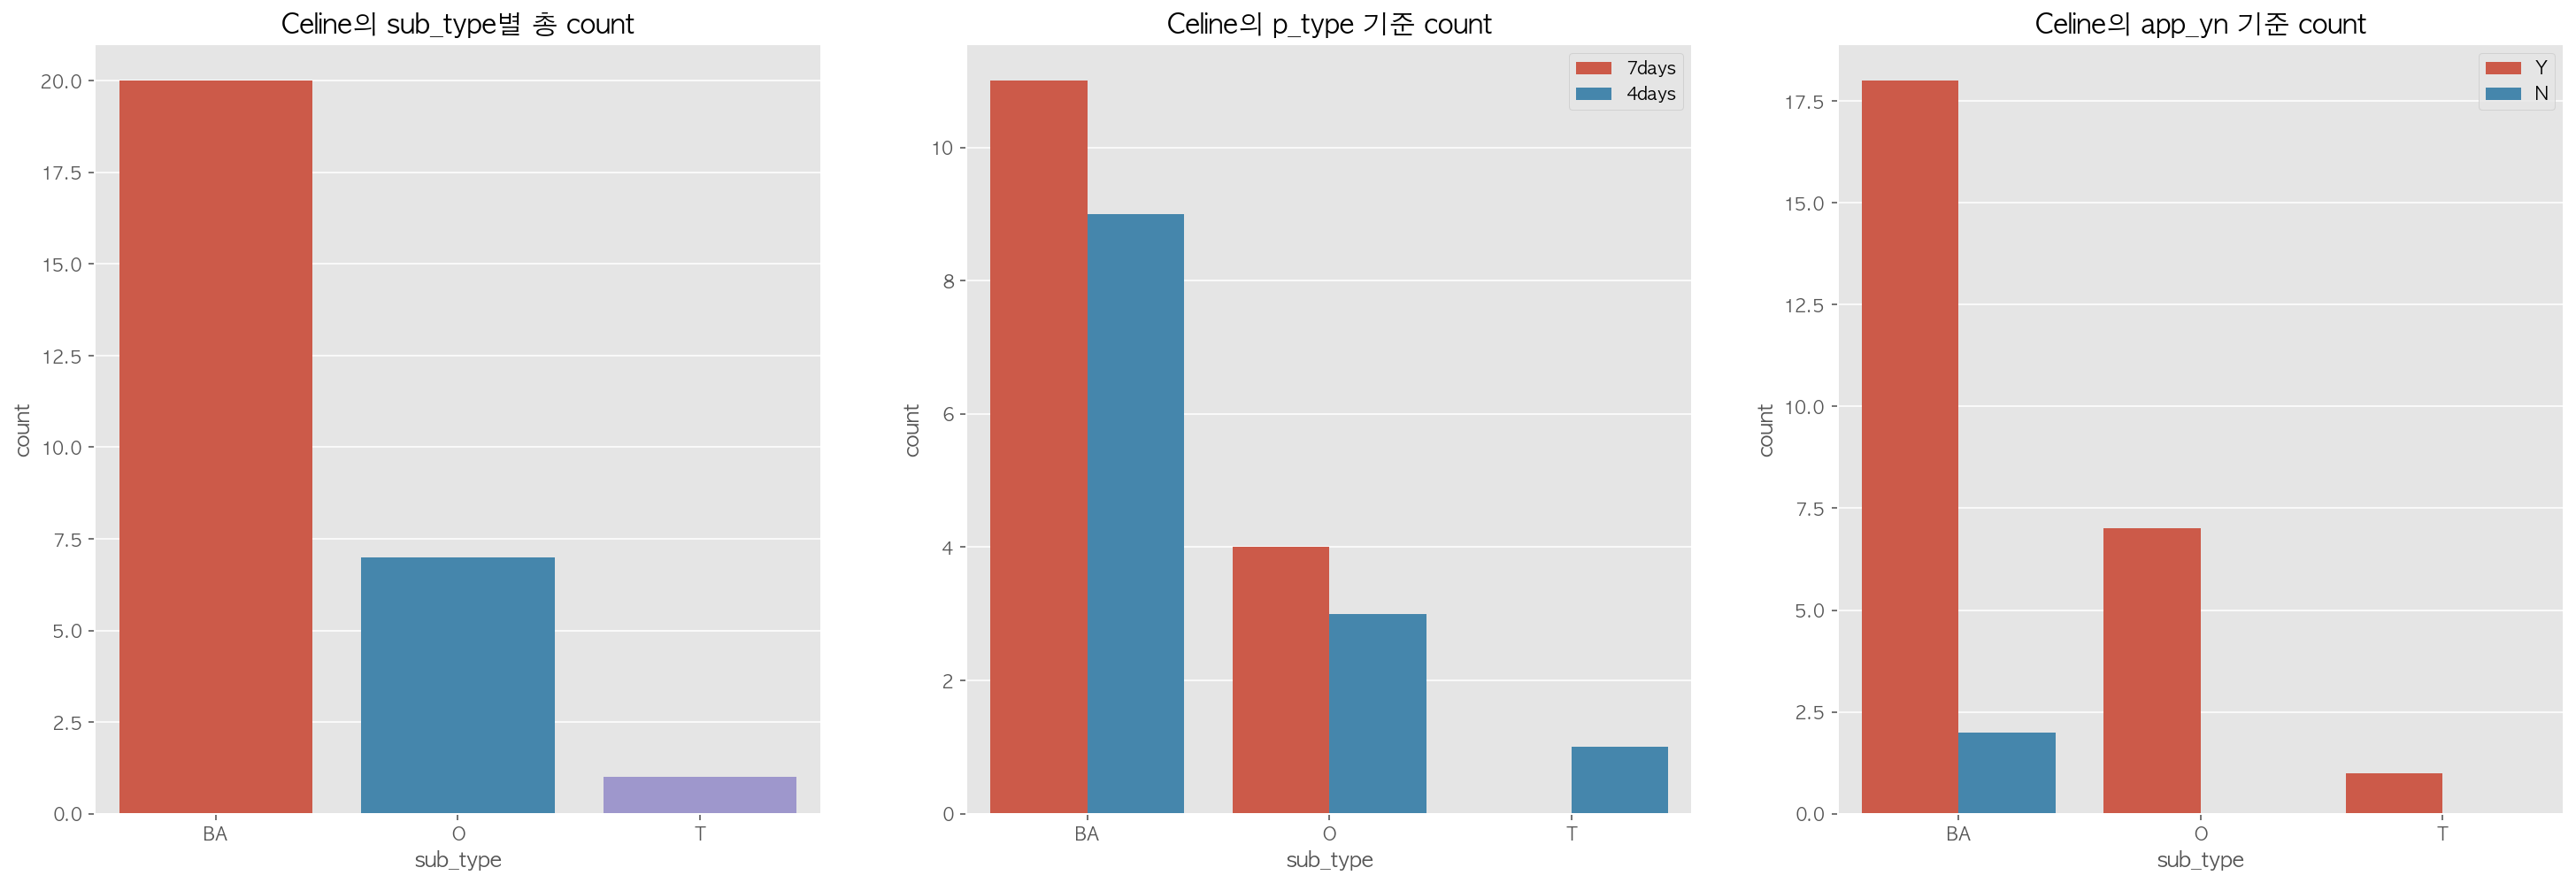

In [19]:
brand_top10 = df.groupby('brandnm').count().sort_values(by='USER',ascending=False)['USER'].head(10).index

# 그래프 그리기
for i in brand_top10:
    brand = df[df['brandnm']==i].sort_values(by='sub_type')

    f, ax = plt.subplots(1, 3, figsize = (25,8))
    sns.countplot(data=brand, x='sub_type',  ax=ax[0])
    sns.countplot(data=brand, x='sub_type', hue='p_type', ax=ax[1])
    sns.countplot(data=brand, x='sub_type', hue='app_yn', ax=ax[2])
    
    ax[0].set_title("%s의 sub_type별 총 count" %i, fontsize = 15)
    ax[1].set_title("%s의 p_type 기준 count" %i, fontsize = 15)  
    ax[2].set_title("%s의 app_yn 기준 count" %i, fontsize = 15)  
    
    ax[1].legend(loc='upper right')
    ax[2].legend(loc='upper right')
    plt.show()

- 대부분 bag을 가장 선호
- Burberry는 outer을 가장 선호 
- Thom Browne은 bag을 구매하지 않음

## 아이템 카테고리 별 선호도

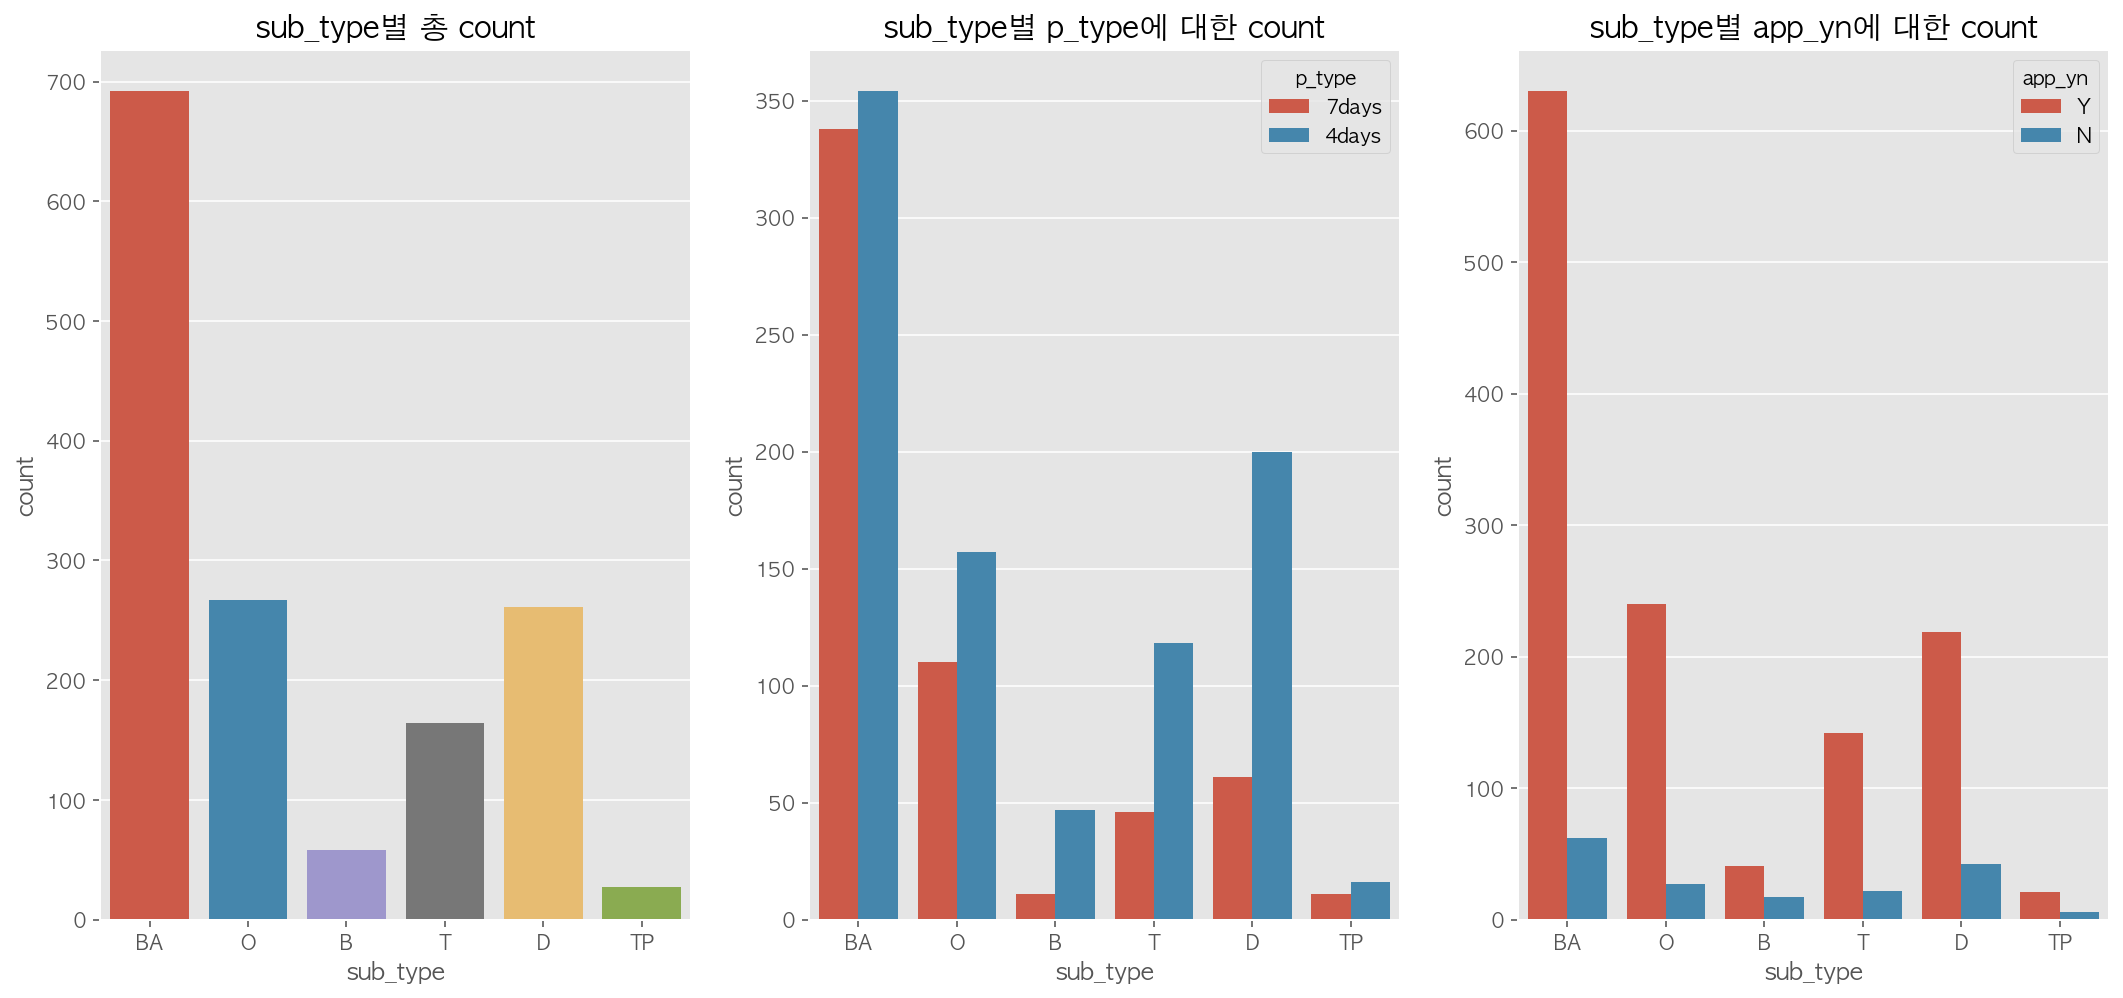

In [20]:
f, ax = plt.subplots(1, 3, figsize = (18,8))

sns.countplot(data=df, x='sub_type', ax=ax[0])
sns.countplot(data=df, x='sub_type', hue='p_type', ax=ax[1])
sns.countplot(data=df, x='sub_type', hue='app_yn', ax=ax[2])

ax[0].set_title("sub_type별 총 count", fontsize = 15)
ax[1].set_title("sub_type별 p_type에 대한 count", fontsize = 15)  
ax[2].set_title("sub_type별 app_yn에 대한 count", fontsize = 15)  
    
plt.show()

### 브랜드에 대한 선호도

In [21]:
# 상품별 많이 구매한 브랜드 top10 추출
sub_type = df['sub_type'].unique()

for i in sub_type :
    print(f"많이 구매한 브랜드 top10 - %s"%i)
    print(df[df['sub_type']==i].groupby('brandnm').count().sort_values(by='USER',ascending=False)['USER'].head(10))
    print("")

많이 구매한 브랜드 top10 - BA
brandnm
Gucci                 204
Saint Laurent          84
Louis Vuitton          77
Chanel                 75
Prada                  38
Yves Saint Laurent     34
Fendi                  23
Celine                 20
Christian Dior         15
Chloe                  12
Name: USER, dtype: int64

많이 구매한 브랜드 top10 - O
brandnm
Burberry           30
Max Mara           18
Prada              16
Chanel             13
Thom Browne        13
Balmain             7
Celine              7
Theory              7
Molliolli           7
Dolce & Gabbana     6
Name: USER, dtype: int64

많이 구매한 브랜드 top10 - B
brandnm
Sandro               3
Michaa               3
Thom Browne          3
Mine                 2
Calvin Klein         2
Alexander Mcqueen    1
Max Mara             1
Moia                 1
More Or Less         1
On&On                1
Name: USER, dtype: int64

많이 구매한 브랜드 top10 - T
brandnm
Thom Browne            17
Gucci                  14
Burberry               10
El estilo de Clai

### 색상에 대한 선호도 

In [22]:
data['component'] = data['goodsnm'].str.split()

In [23]:
data['color'] = 'none'

def color_ext(color):
    for i in range(len(data)):
        if (color in data['component'][i]): 
            data['color'].iloc[i]=color

In [24]:
color_list = ['beige','black','blue','pink','navy','ivory',
             'white','brown','cream','purple','deeppink',
             'nude','burgundy','grey','red',
            'skyblue', 'gold','mint','green','yellow',
             'collar','charcoal',' khaki','orange','lavender','mustard',
             'wine','salmon','rainbow','bluegreen','black&beige',
             'olive']

for i in color_list:
    color_ext(i)

In [25]:
# 중복 색 처리
for i in range(len(data)):
    if ('gray' in data['component'][i]):
       data['color'].iloc[i] = 'grey'
    if ('gray_1' in data['component'][i]):
       data['color'].iloc[i] = 'grey'
    if ('black1' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    if ('black_1' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    if ('Black' in data['component'][i]):
       data['color'].iloc[i] = 'black'

In [26]:
color = data.groupby('color').count()['USER'].sort_values(ascending=False)[:20].reset_index()

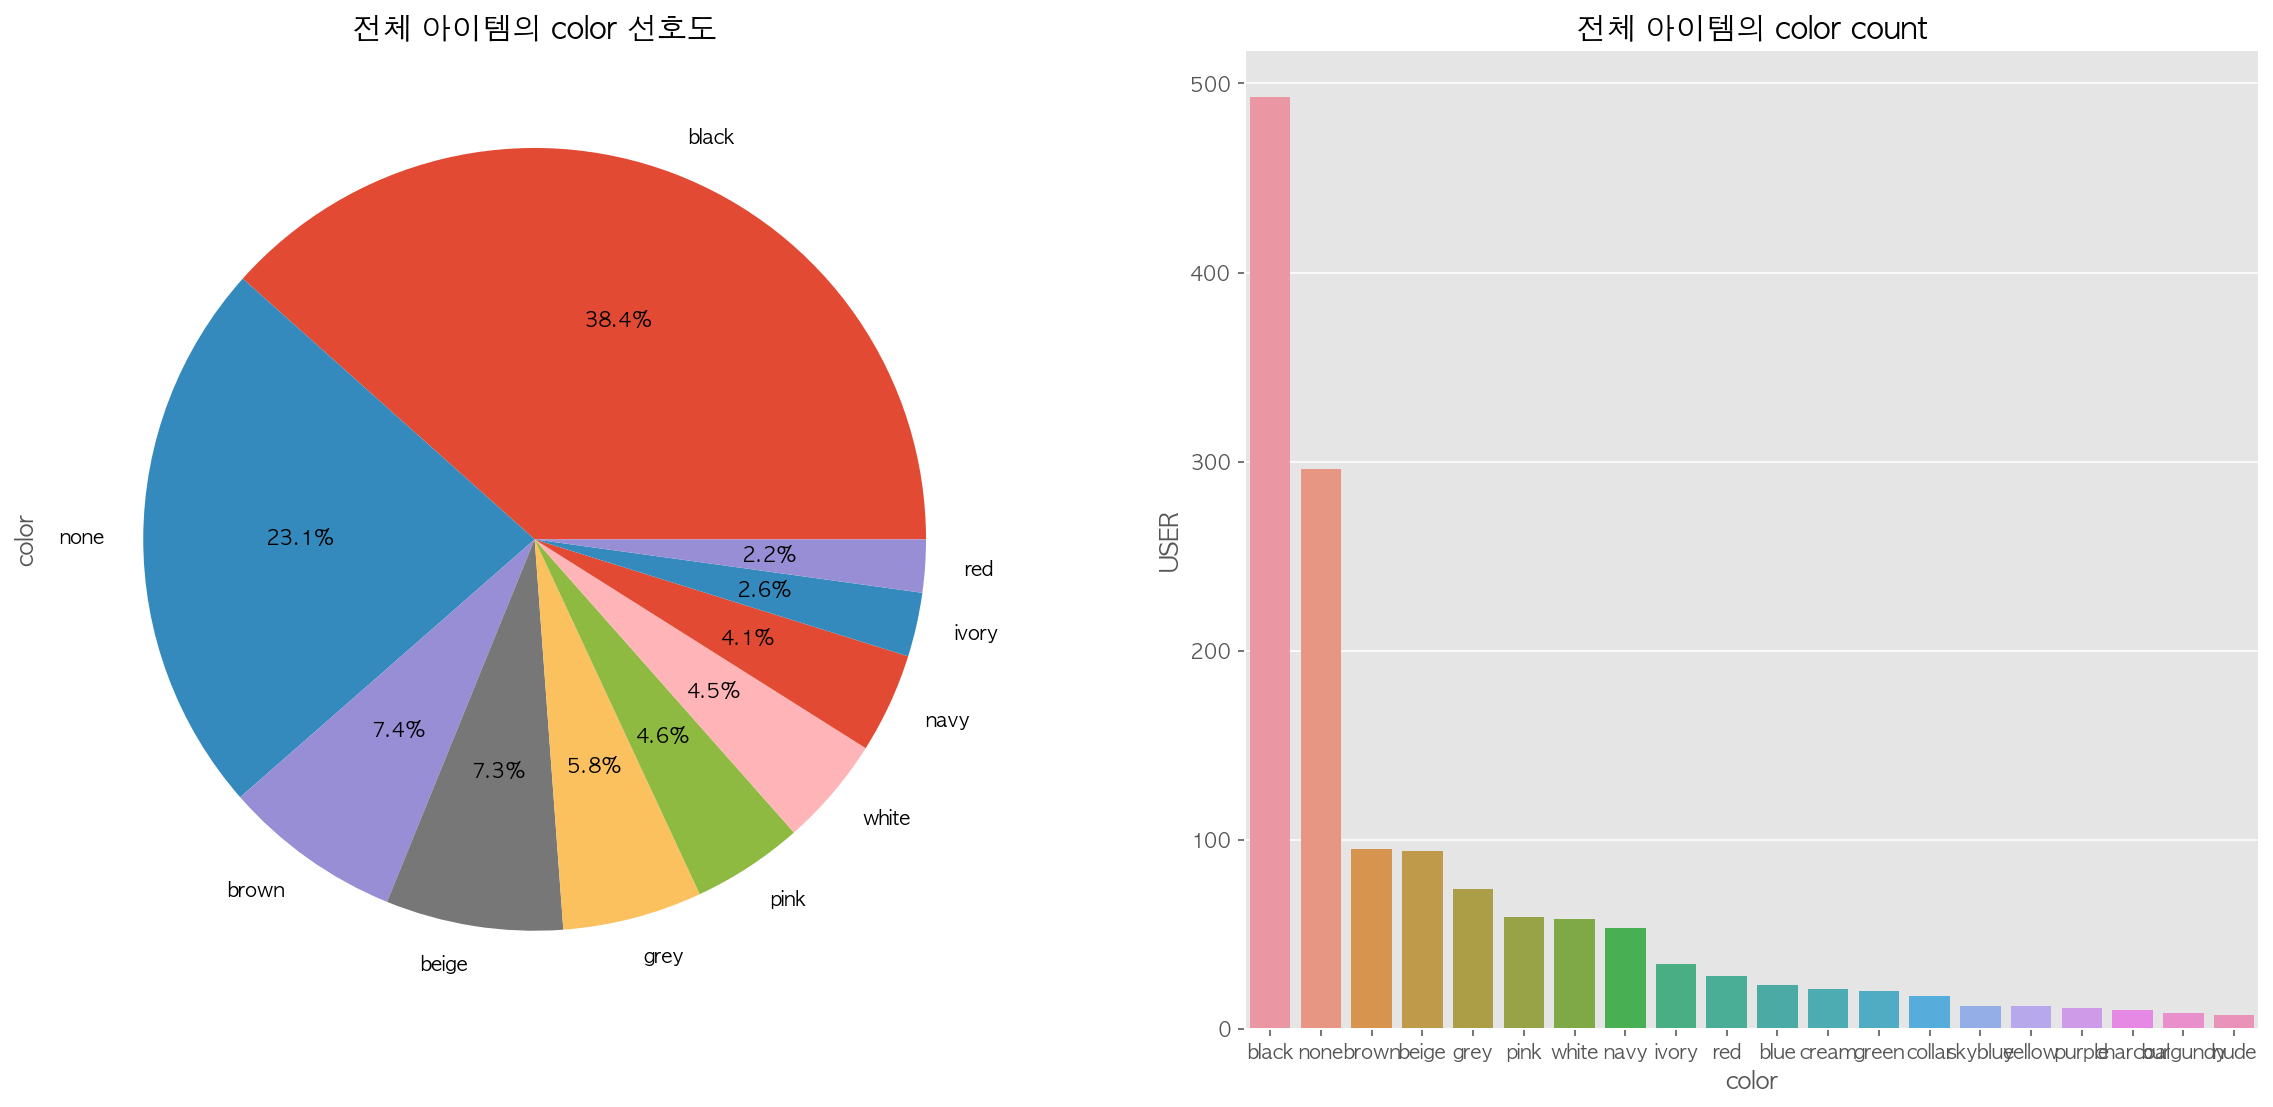

In [27]:
# 전체 아이템에 대한 색상 선호도
f, ax = plt.subplots(1,2, figsize = (20,9))

data['color'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, ax=ax[0])
sns.barplot(data=color, x='color', y='USER', ax=ax[1])

ax[0].set_title("전체 아이템의 color 선호도", fontsize = 15)
ax[1].set_title("전체 아이템의 color count", fontsize = 15)  

plt.show()

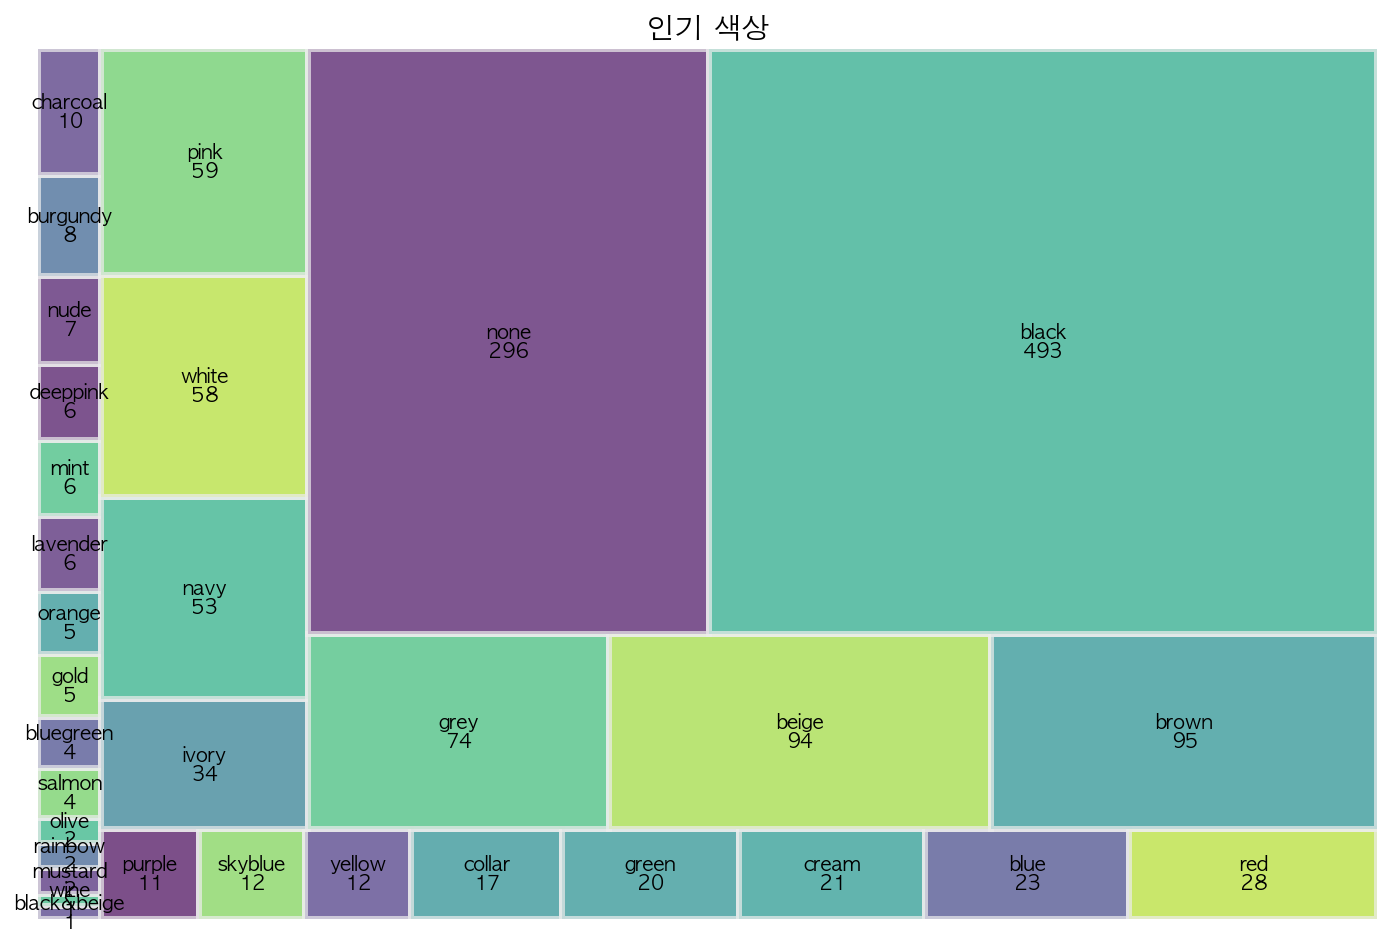

In [28]:
plt.figure(figsize=(12,8))

data_pivot = data.pivot_table(index = 'color', values = 'USER', aggfunc = 'count').sort_values('USER')
squarify.plot(sizes=data_pivot['USER'], label = data_pivot.index, value = data_pivot['USER'], alpha=0.7,bar_kwargs=dict(linewidth=3, edgecolor="#eee"))

plt.axis('off')
plt.title('인기 색상')

plt.show()

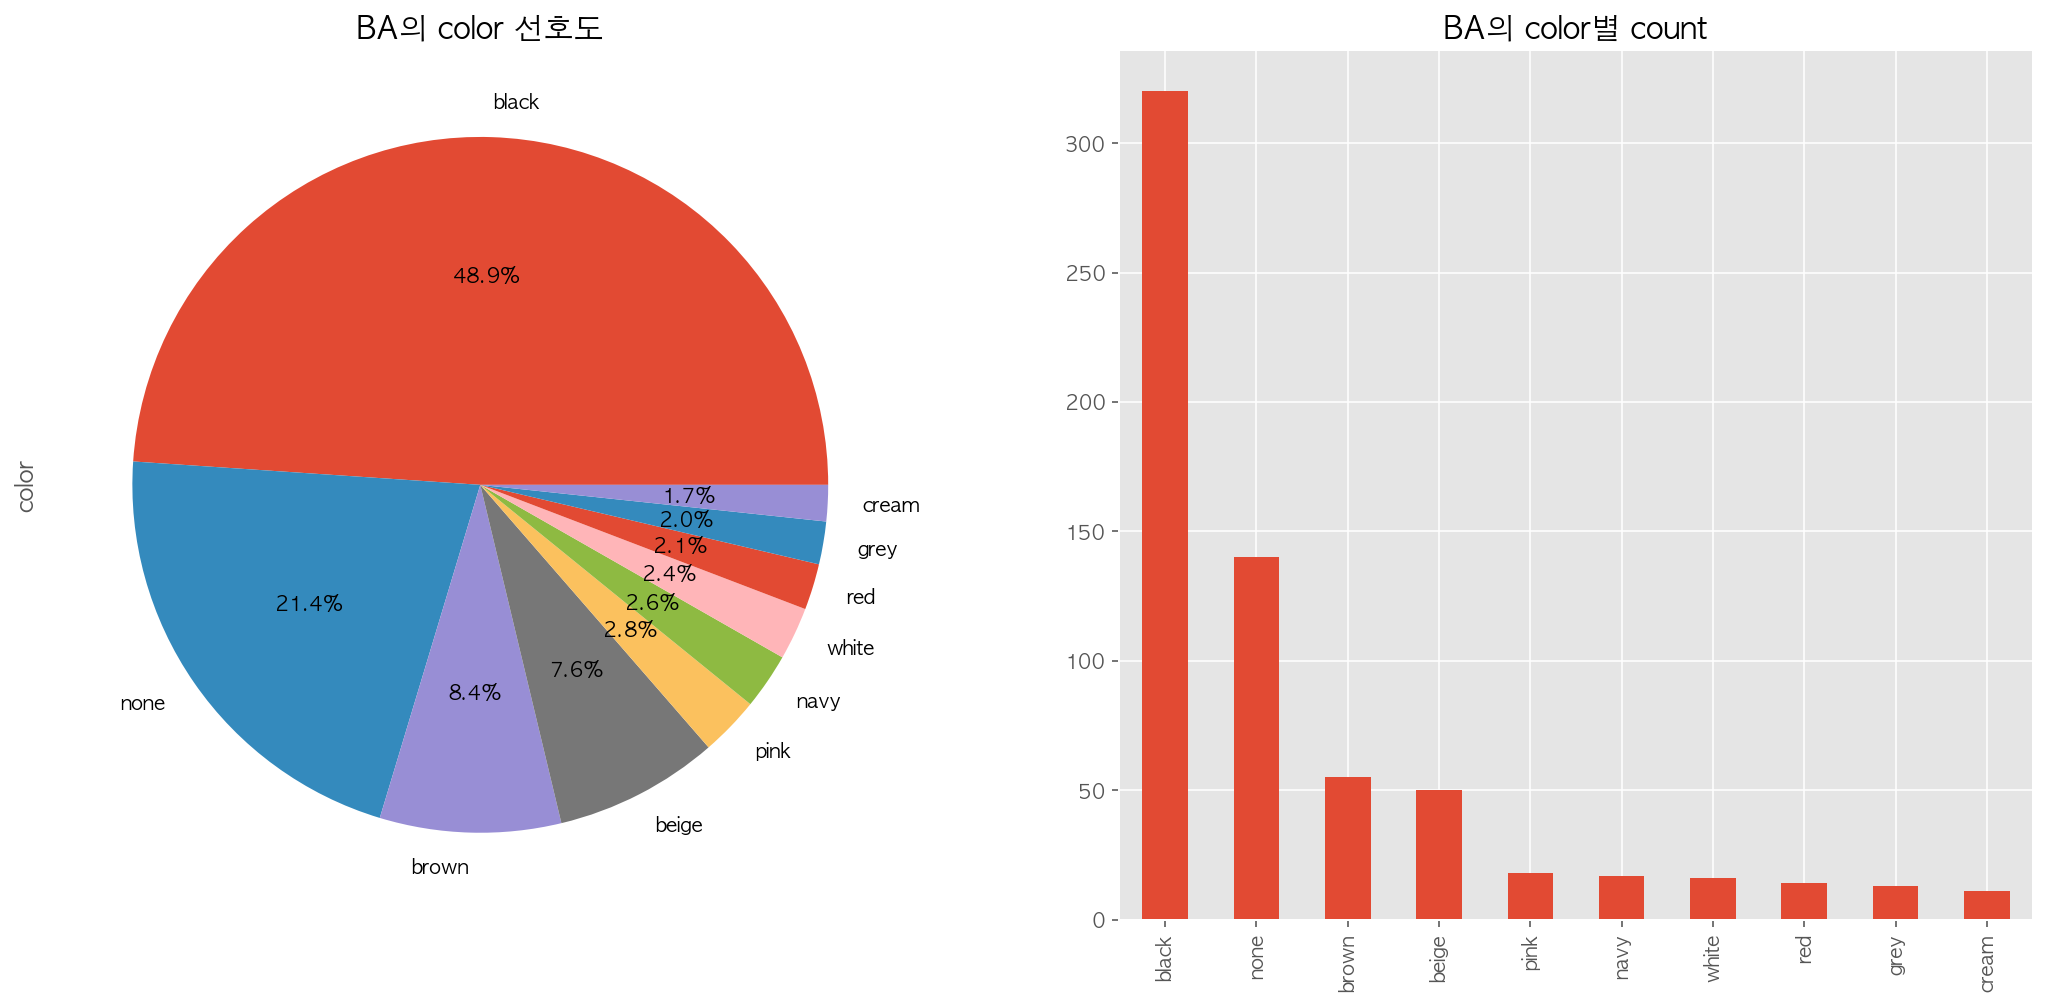

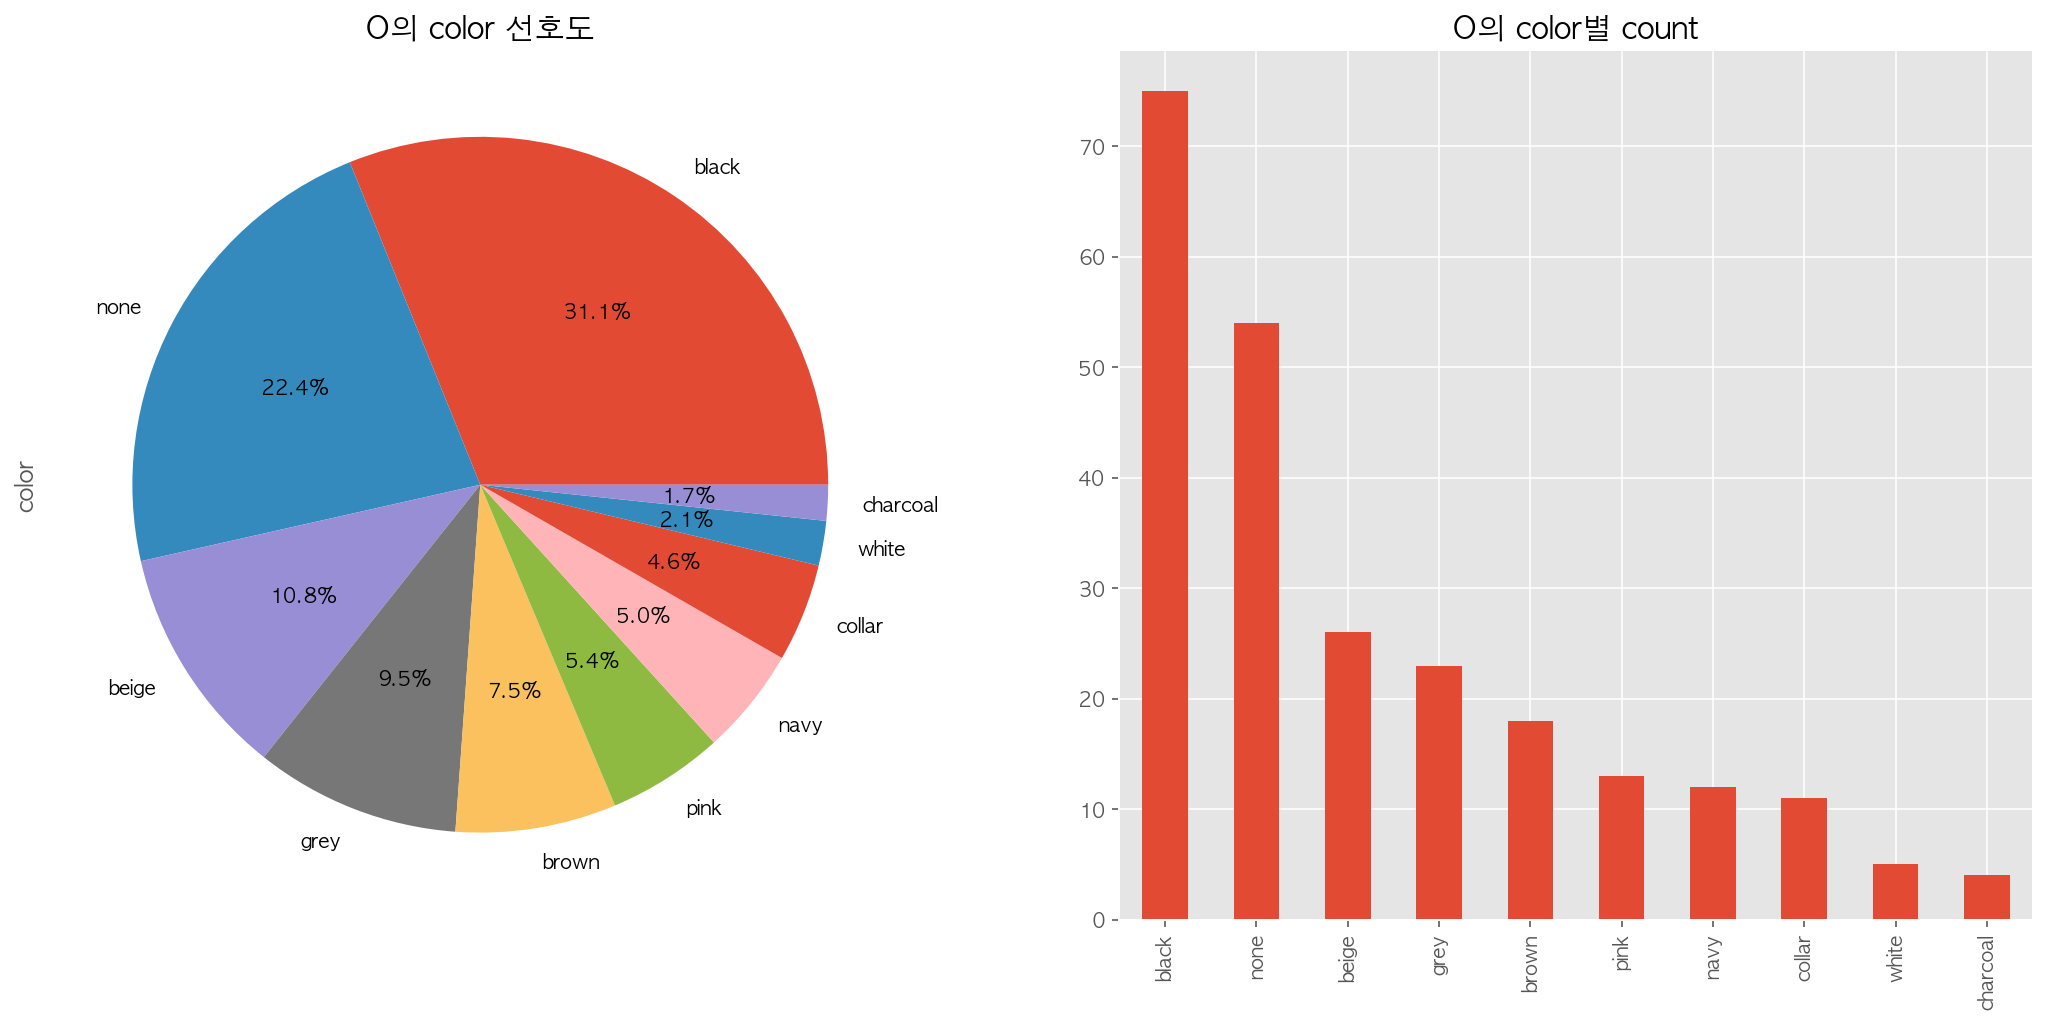

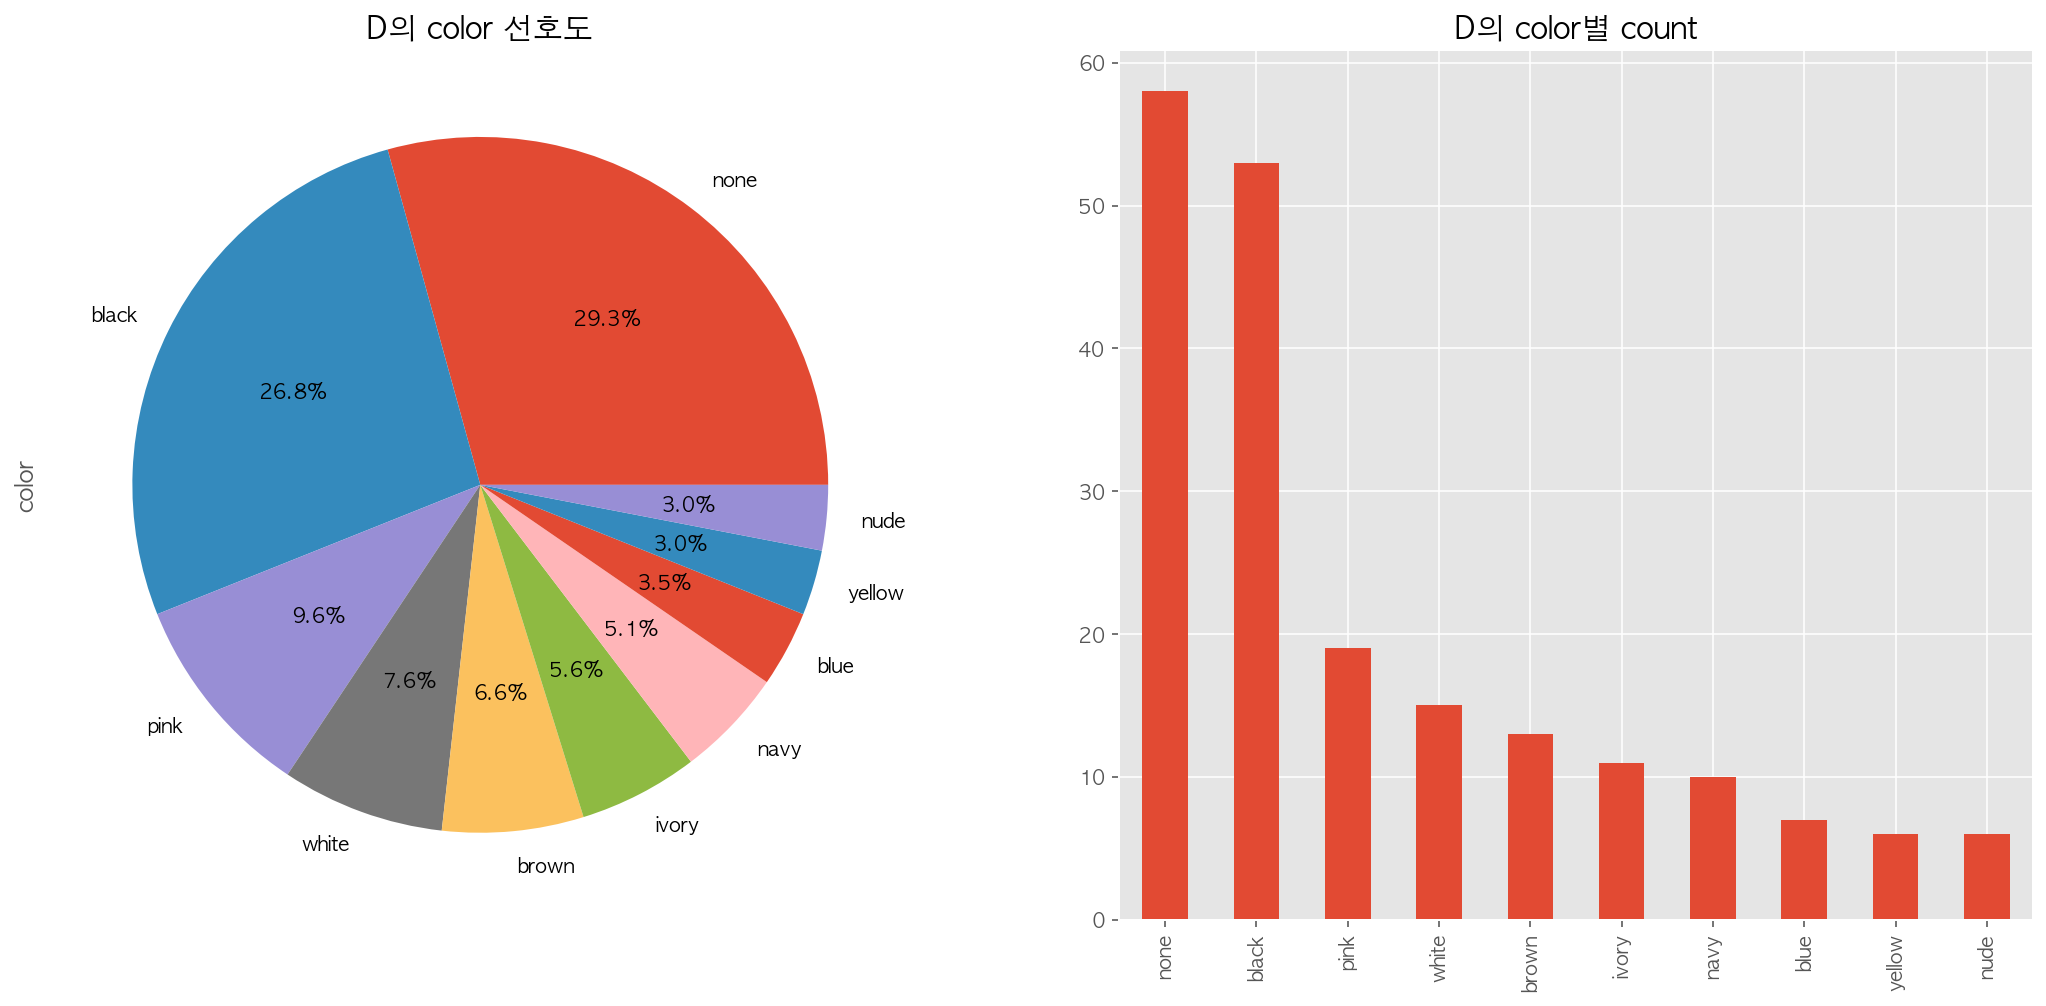

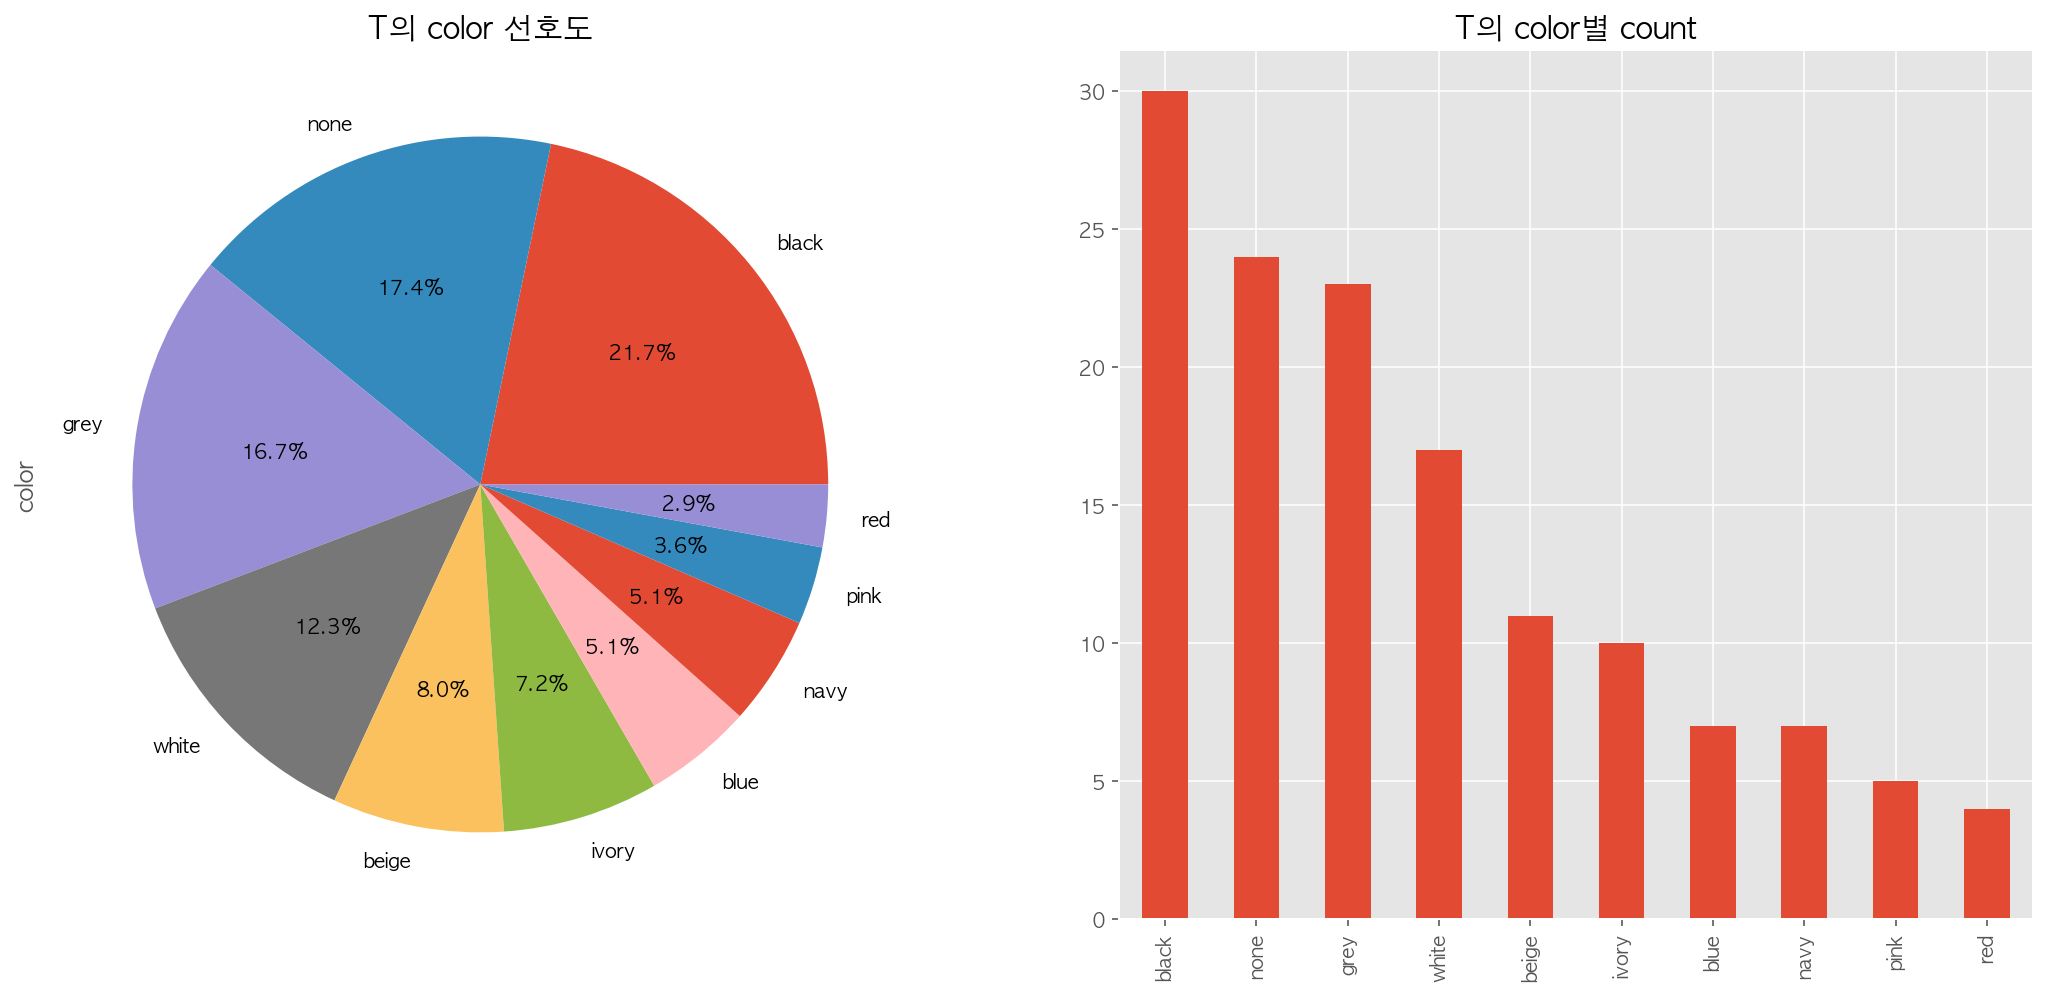

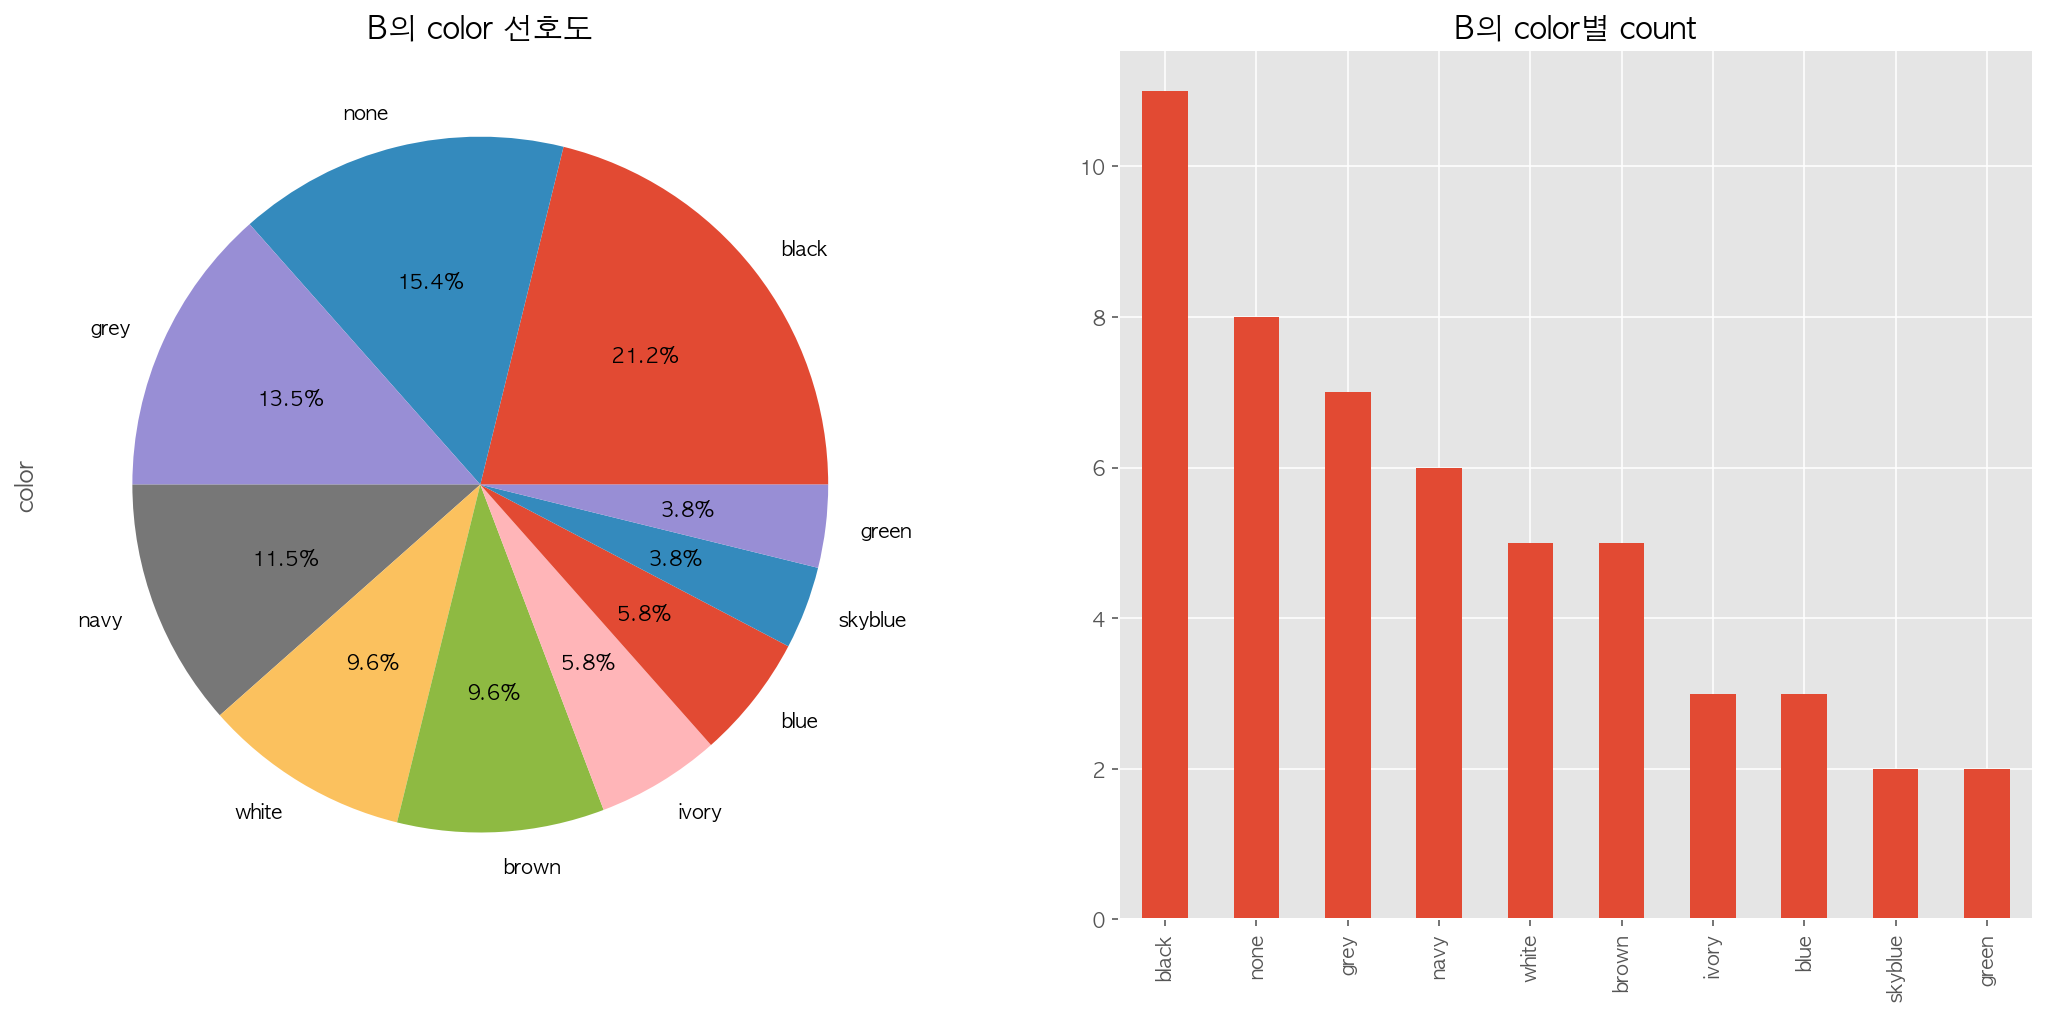

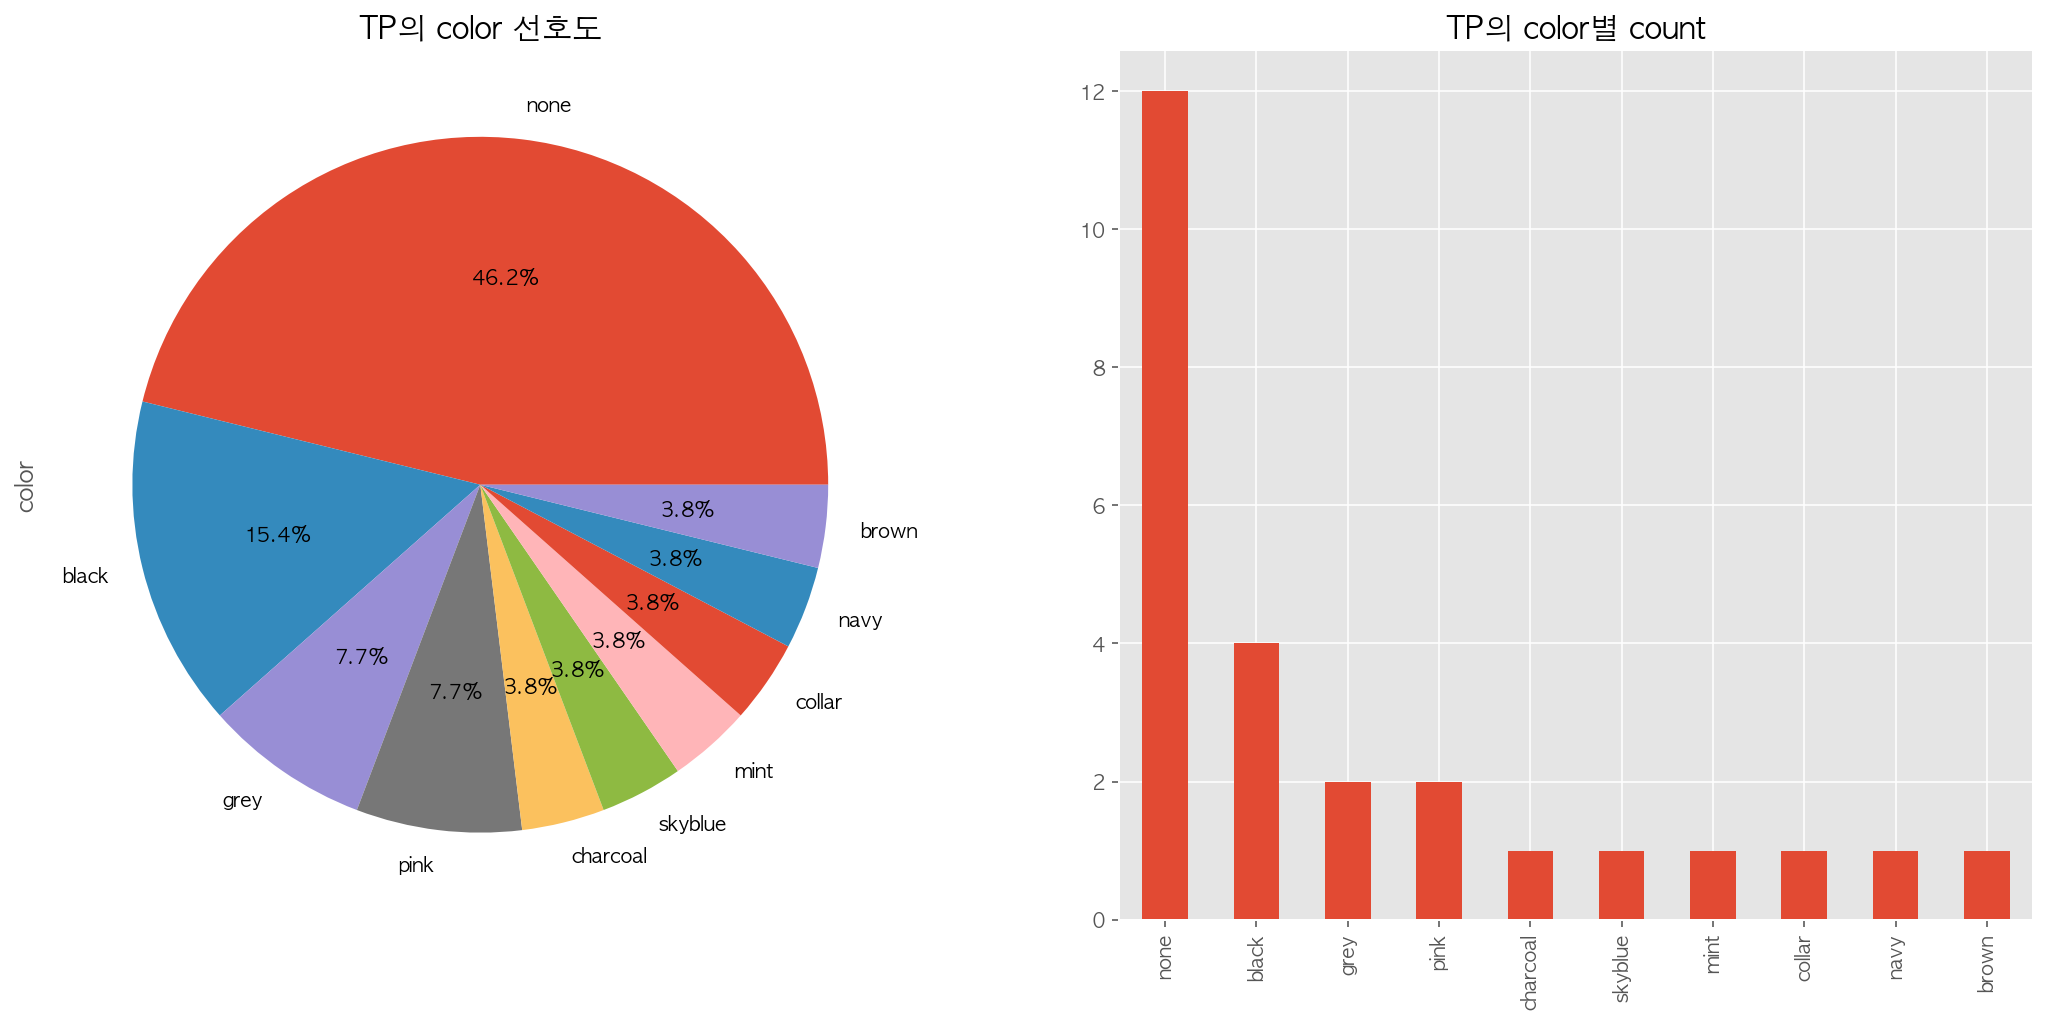

In [30]:
# 아이템 카테고리별 색상 선호도
list = data['sub_type'].value_counts().index

for i in list:
    f, ax = plt.subplots(1, 2, figsize = (18,8))

    data[data['sub_type']==i]['color'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, ax=ax[0])
    data[data['sub_type']==i]['color'].value_counts()[:10].plot(kind='bar', ax=ax[1])

    ax[0].set_title("%s의 color 선호도"%i, fontsize = 15)
    ax[1].set_title("%s의 color별 count"%i, fontsize = 15)  

    plt.show()

### 제품에 대한 선호도

In [31]:
data['item'] = 'none'

def item_exit(item):
    for i in range(len(data)):
        if (item in data['component'][i]): 
            data['item'].iloc[i]=item

In [32]:
item_list = ['shoulder','jacket','skirt','top','zipup-jumper','coat',
             'fur-outer','cross','cardigan','padding','small',
             'hobo','dress','sweater','bucket',
            'sweat-shirts', 'jumper','turtle','body','lady',
             'clutch','mini',' shirt-dress','t-shirts','sleeveless','slacks',
             'blazer','medium', 'blouse', 'tote', 'belt', 'monogramtote',
            'hoodie', 'doublebreasted-jacket', 'duffle-coat', 'padding-outer',
            'crossbody', 'jump-suit', 'shirt', 'satchel', 'trench-coat', 'logo',
            'doublebreasted-coat', 'vest', 'shirts', 'way', 'chain',
            'singlebreated-jacket', 'box', 'dionysus', 'monogram', 'saffiano',
            'regular', 'moon', 'handle', '2jours', 'chino-pants', 'city',
            'tee', 'crossbody', 'satchel']

for i in item_list:
    item_exit(i)

In [33]:
# 중복 처리
for i in range(len(data)):
    if ('shoulder' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('clutch' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('mini' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('logo' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('tote' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('cross' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('chain' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('body' in data['component'][i]):
       data['item'].iloc[i] = 'bag'

In [34]:
item = data.groupby('item').count()['USER'].sort_values(ascending=False)[:20].reset_index()

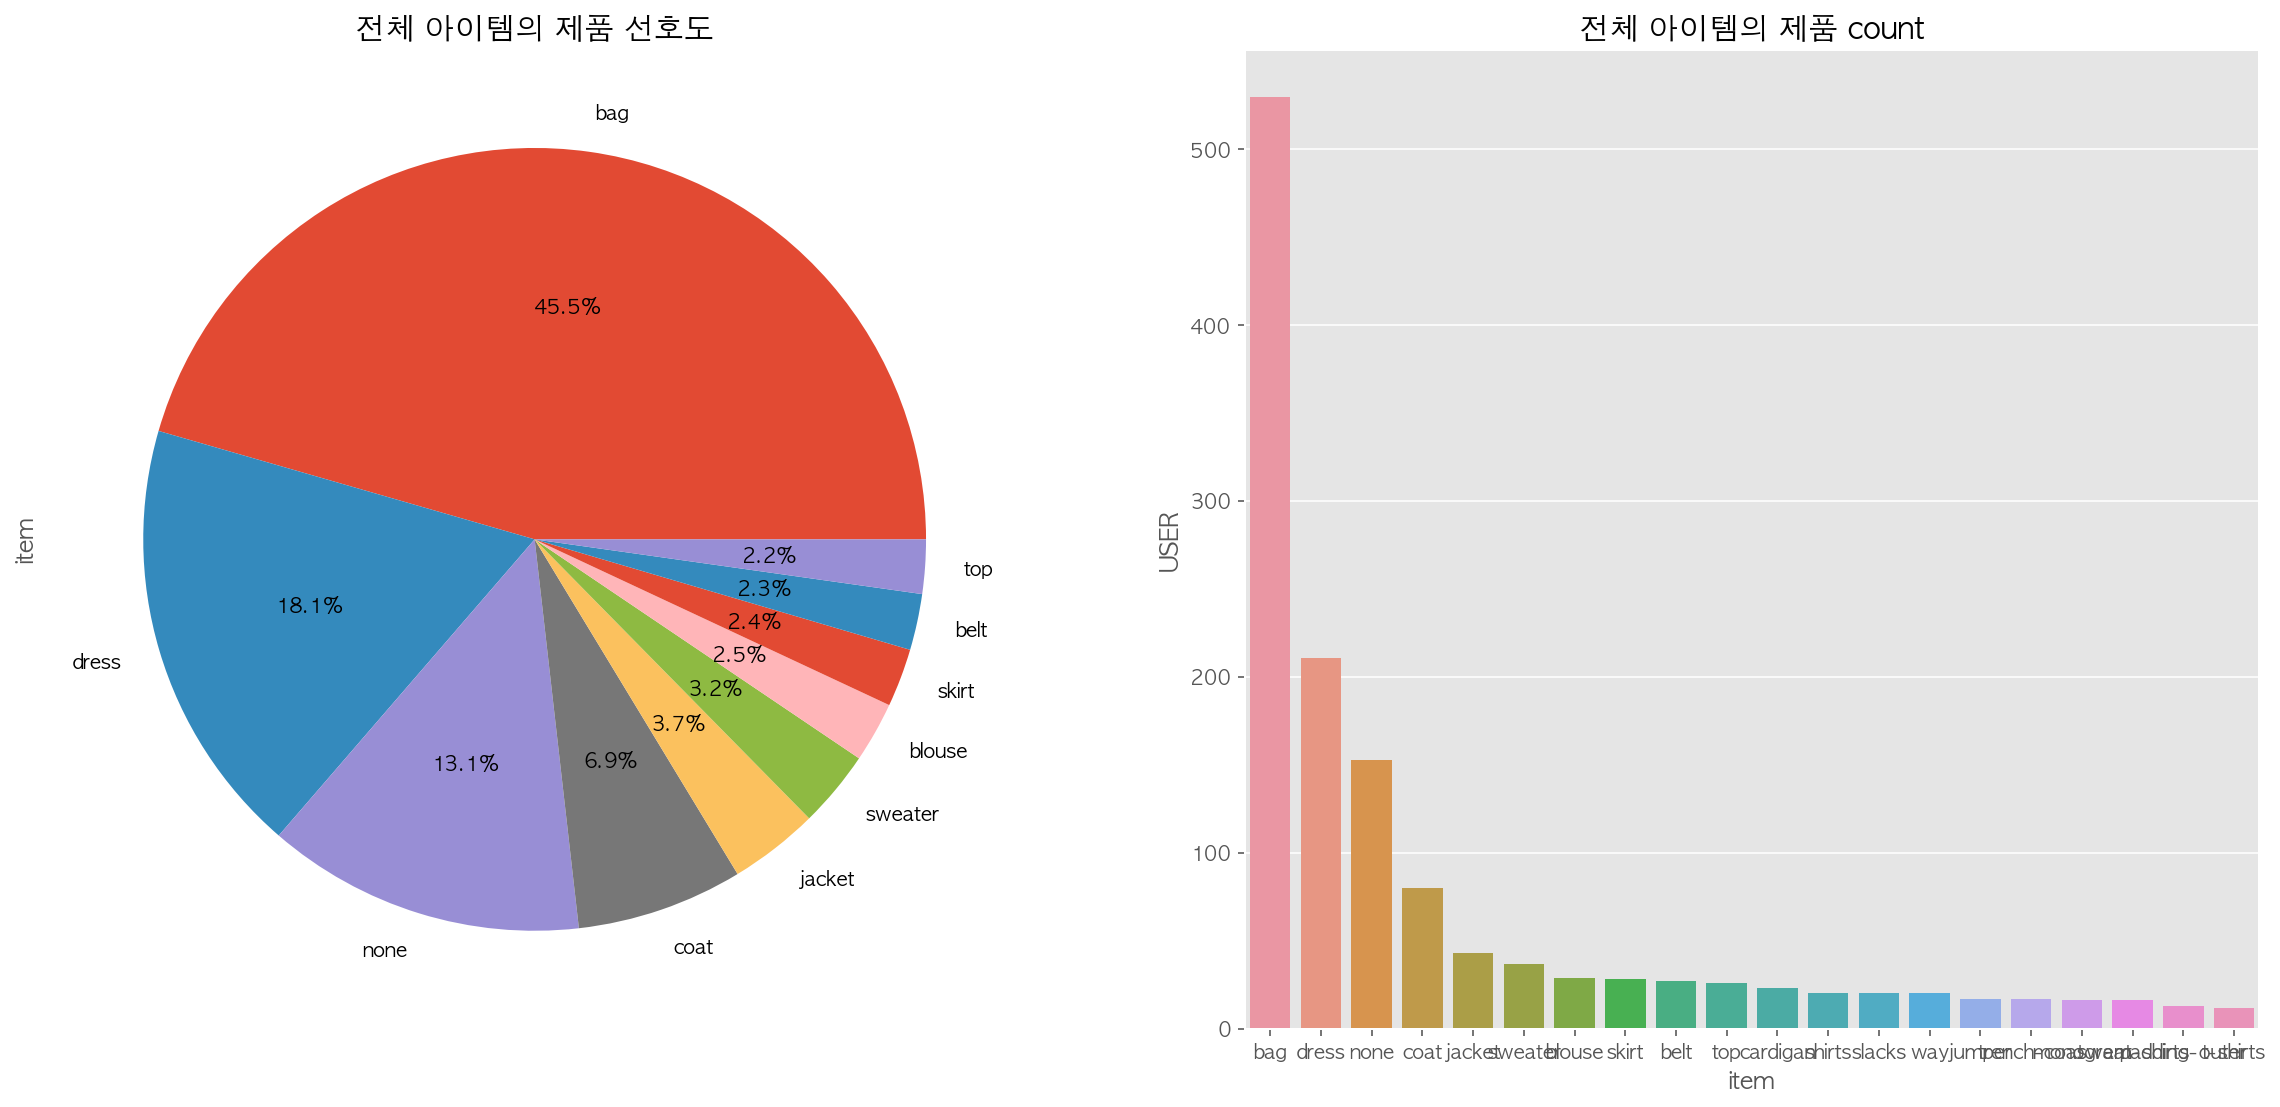

In [35]:
# 전체 아이템에 대한 제품 선호도
f, ax = plt.subplots(1,2, figsize = (20,9))

data['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, ax=ax[0])
sns.barplot(data=item, x='item', y='USER', ax=ax[1])

ax[0].set_title("전체 아이템의 제품 선호도", fontsize = 15)
ax[1].set_title("전체 아이템의 제품 count", fontsize = 15)  

plt.show()

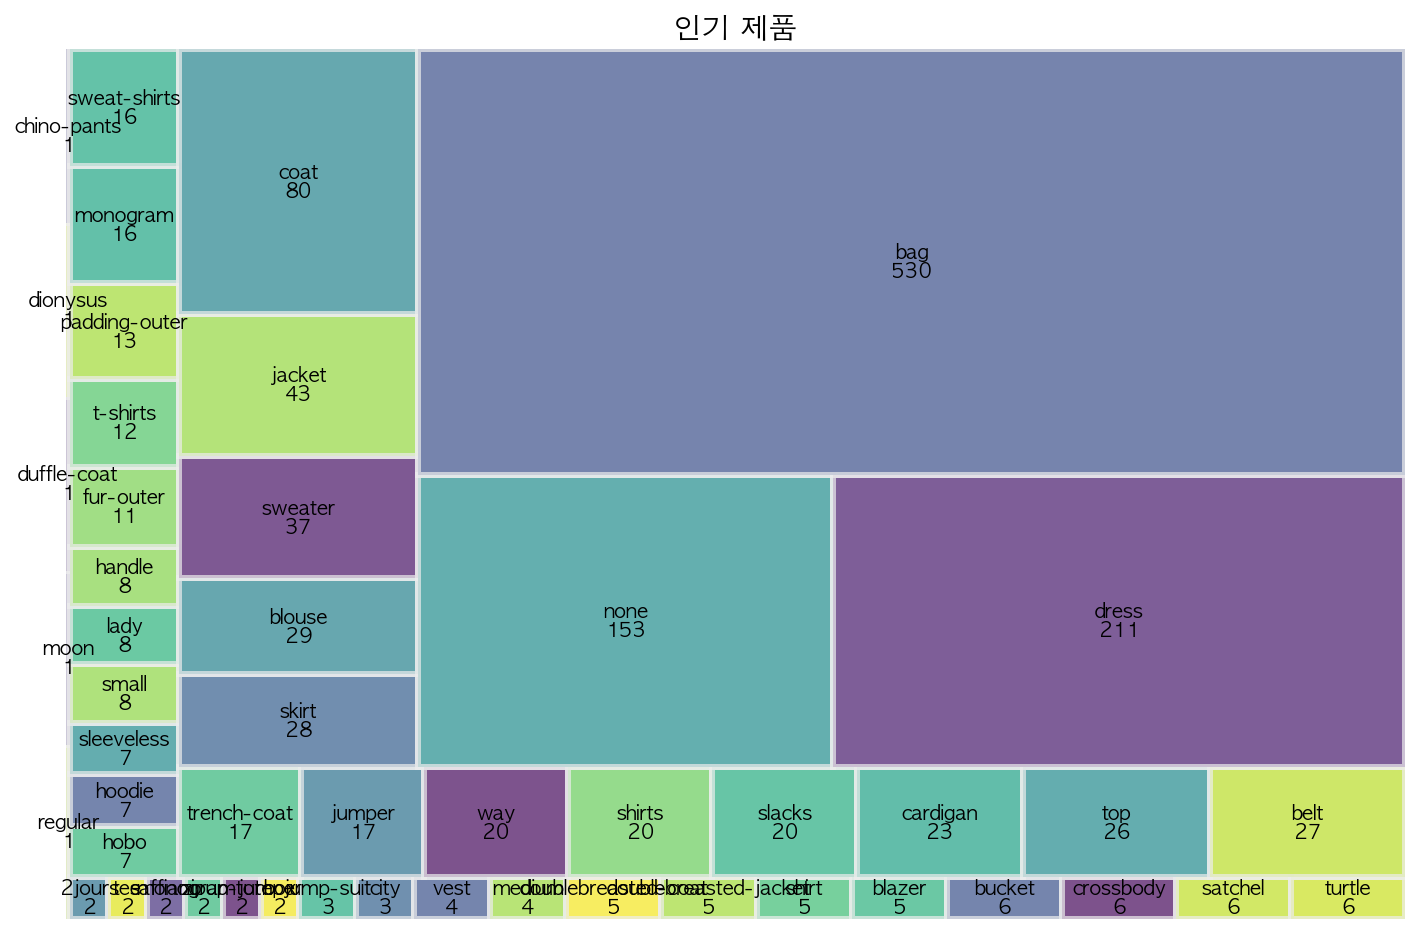

In [36]:
plt.figure(figsize=(12,8))
data_pivot = data.pivot_table(index = 'item', values = 'USER', aggfunc = 'count').sort_values('USER')
squarify.plot(sizes=data_pivot['USER'], label = data_pivot.index, value = data_pivot['USER'], alpha=0.7,bar_kwargs=dict(linewidth=3, edgecolor="#eee"))
plt.axis('off')
plt.title('인기 제품')
plt.show()

index              brandnm  \
0        0                Gucci   
1        8                Gucci   
2       10        Louis Vuitton   
3       11           Tory Burch   
4       14                Chloe   
5       15                Prada   
6       16                Gucci   
7       23                Fendi   
8       27                Fendi   
9       30                Prada   
10      32                 Dior   
11      33       Bottega Veneta   
12      34                Gucci   
13      36                Gucci   
14      38                Gucci   
15      43                Gucci   
16      44        Louis Vuitton   
17      45        Saint Laurent   
18      46                Gucci   
19      51        Saint Laurent   
20      54               Celine   
21      56        Saint Laurent   
22      62                Gucci   
23      63   Yves Saint Laurent   
24      64                Gucci   
25      71       Christian Dior   
26      73        Louis Vuitton   
27      83                Gucci   
28      84        Biker Starlet   
29      91        Louis Vuitton   
30      92                Gucci   
31      93                Gucci   
32      97             Givenchy   
33      98               Chanel   
34      99                Gucci   
35     100                Gucci   
36     101  Salvatore Ferragamo   
37     102                Gucci   
38     108    Vivienne Westwood   
39     110                Chloe   
40     115        Saint Laurent   
41     119       Christian Dior   
42     122       Bottega Veneta   
43     123                Prada   
44     124       Christian Dior   
45     126               Celine   
46     129                Gucci   
47     130                Gucci   
48     139                Gucci   
49     140   Yves Saint Laurent   
50     141                Gucci   
51     142               Chanel   
52     144        Louis Vuitton   
53     151        Saint Laurent   
54     153                Fendi   
55     154        Saint Laurent   
56     155        Louis Vuitton   
57     158                Gucci   
58     159        Louis Vuitton   
59     161       Christian Dior   
60     163                Fendi   
61     165       Christian Dior   
62     167                Gucci   
63     171                Prada   
64     174                Gucci   
65     175               Chanel   
66     178                Gucci   
67     180                Gucci   
68     182             Burberry   
69     183                Gucci   
70     184       Bottega Veneta   
71     186               Chanel   
72     188               Chanel   
73     189        Saint Laurent   
74     190                Gucci   
75     191               Chanel   
76     194        Saint Laurent   
77     195        Saint Laurent   
78     198               Vunque   
79     201               Celine   
80     202  Salvatore Ferragamo   
81     204                Gucci   
82     206       Christian Dior   
83     218                Gucci   
84     221             Burberry   
85     222        Saint Laurent   
86     228               Celine   
87     231           Balenciaga   
88     232                Gucci   
89     233   Yves Saint Laurent   
90     235                Prada   
91     239                Gucci   
92     240  Salvatore Ferragamo   
93     242                Gucci   
94     243   Yves Saint Laurent   
95     244   Yves Saint Laurent   
96     245                Gucci   
97     246               Chanel   
98     247       Bottega Veneta   
99     252   Yves Saint Laurent   
100    261   Yves Saint Laurent   
101    262                Prada   
102    263        Saint Laurent   
103    264        Saint Laurent   
104    265                Gucci   
105    266                Gucci   
106    268        Louis Vuitton   
107    269              Delvaux   
108    272                Prada   
109    274           Balenciaga   
110    277   Yves Saint Laurent   
111    281        Louis Vuitton   
112    284                 Dior   
113    286     

In [46]:
# BAG의 세부 제품 선호도 
bag = data.query('sub_type=="BA"').reset_index()

bag['item'] = 'none'

def item_exit(item):
    for i in range(len(bag)):
        if (item in bag['component'][i]): 
            bag['item'].iloc[i]=item

In [47]:
bag

index              brandnm  \
0        0                Gucci   
1        8                Gucci   
2       10        Louis Vuitton   
3       11           Tory Burch   
4       14                Chloe   
5       15                Prada   
6       16                Gucci   
7       23                Fendi   
8       27                Fendi   
9       30                Prada   
10      32                 Dior   
11      33       Bottega Veneta   
12      34                Gucci   
13      36                Gucci   
14      38                Gucci   
15      43                Gucci   
16      44        Louis Vuitton   
17      45        Saint Laurent   
18      46                Gucci   
19      51        Saint Laurent   
20      54               Celine   
21      56        Saint Laurent   
22      62                Gucci   
23      63   Yves Saint Laurent   
24      64                Gucci   
25      71       Christian Dior   
26      73        Louis Vuitton   
27      83                Gucci   
28      84        Biker Starlet   
29      91        Louis Vuitton   
30      92                Gucci   
31      93                Gucci   
32      97             Givenchy   
33      98               Chanel   
34      99                Gucci   
35     100                Gucci   
36     101  Salvatore Ferragamo   
37     102                Gucci   
38     108    Vivienne Westwood   
39     110                Chloe   
40     115        Saint Laurent   
41     119       Christian Dior   
42     122       Bottega Veneta   
43     123                Prada   
44     124       Christian Dior   
45     126               Celine   
46     129                Gucci   
47     130                Gucci   
48     139                Gucci   
49     140   Yves Saint Laurent   
50     141                Gucci   
51     142               Chanel   
52     144        Louis Vuitton   
53     151        Saint Laurent   
54     153                Fendi   
55     154        Saint Laurent   
56     155        Louis Vuitton   
57     158                Gucci   
58     159        Louis Vuitton   
59     161       Christian Dior   
60     163                Fendi   
61     165       Christian Dior   
62     167                Gucci   
63     171                Prada   
64     174                Gucci   
65     175               Chanel   
66     178                Gucci   
67     180                Gucci   
68     182             Burberry   
69     183                Gucci   
70     184       Bottega Veneta   
71     186               Chanel   
72     188               Chanel   
73     189        Saint Laurent   
74     190                Gucci   
75     191               Chanel   
76     194        Saint Laurent   
77     195        Saint Laurent   
78     198               Vunque   
79     201               Celine   
80     202  Salvatore Ferragamo   
81     204                Gucci   
82     206       Christian Dior   
83     218                Gucci   
84     221             Burberry   
85     222        Saint Laurent   
86     228               Celine   
87     231           Balenciaga   
88     232                Gucci   
89     233   Yves Saint Laurent   
90     235                Prada   
91     239                Gucci   
92     240  Salvatore Ferragamo   
93     242                Gucci   
94     243   Yves Saint Laurent   
95     244   Yves Saint Laurent   
96     245                Gucci   
97     246               Chanel   
98     247       Bottega Veneta   
99     252   Yves Saint Laurent   
100    261   Yves Saint Laurent   
101    262                Prada   
102    263        Saint Laurent   
103    264        Saint Laurent   
104    265                Gucci   
105    266                Gucci   
106    268        Louis Vuitton   
107    269              Delvaux   
108    272                Prada   
109    274           Balenciaga   
110    277   Yves Saint Laurent   
111    281        Louis Vuitton   
112    284                 Dior   
113    286     

In [59]:
bag_list = ['tote','shoulder','cross','clutch','backpack', 'Backpack'
            'belt','bucket','lady','luggage', 'Luggage','emily','hobo', 'small',
           'way','medium', 'drew', 'backpack', 'logo', 'mini', 'dionysus',
           'monogramotote', 'bucket', 'patent', 'satchel', 'lux', 'vitello',
           'lily', 'flab', 'lettering', 'city', 'candy', 'topaz', 'muse',
           'dotcom', 'caviar', 'bobby', 'monogram', 'classic', 'escale',
           'pionniere', 'vanity', 'regular', 'moon', 'discover', 'serpenti',
           'antigona', 'handle', 'vertical', 'boston', 'trio', 'crossbody'] 
    
for i in bag_list:
    item_exit(i)

# 중복처리    
for i in range(len(bag)):
    if ('crossbody' in bag['component'][i]):
       bag['item'].iloc[i] = 'cross'
    if ('luggage' in bag['component'][i]):
       bag['item'].iloc[i] = 'Luggage'
    if ('backpack' in bag['component'][i]):
       bag['item'].iloc[i] = 'Backpack'
    
    
    

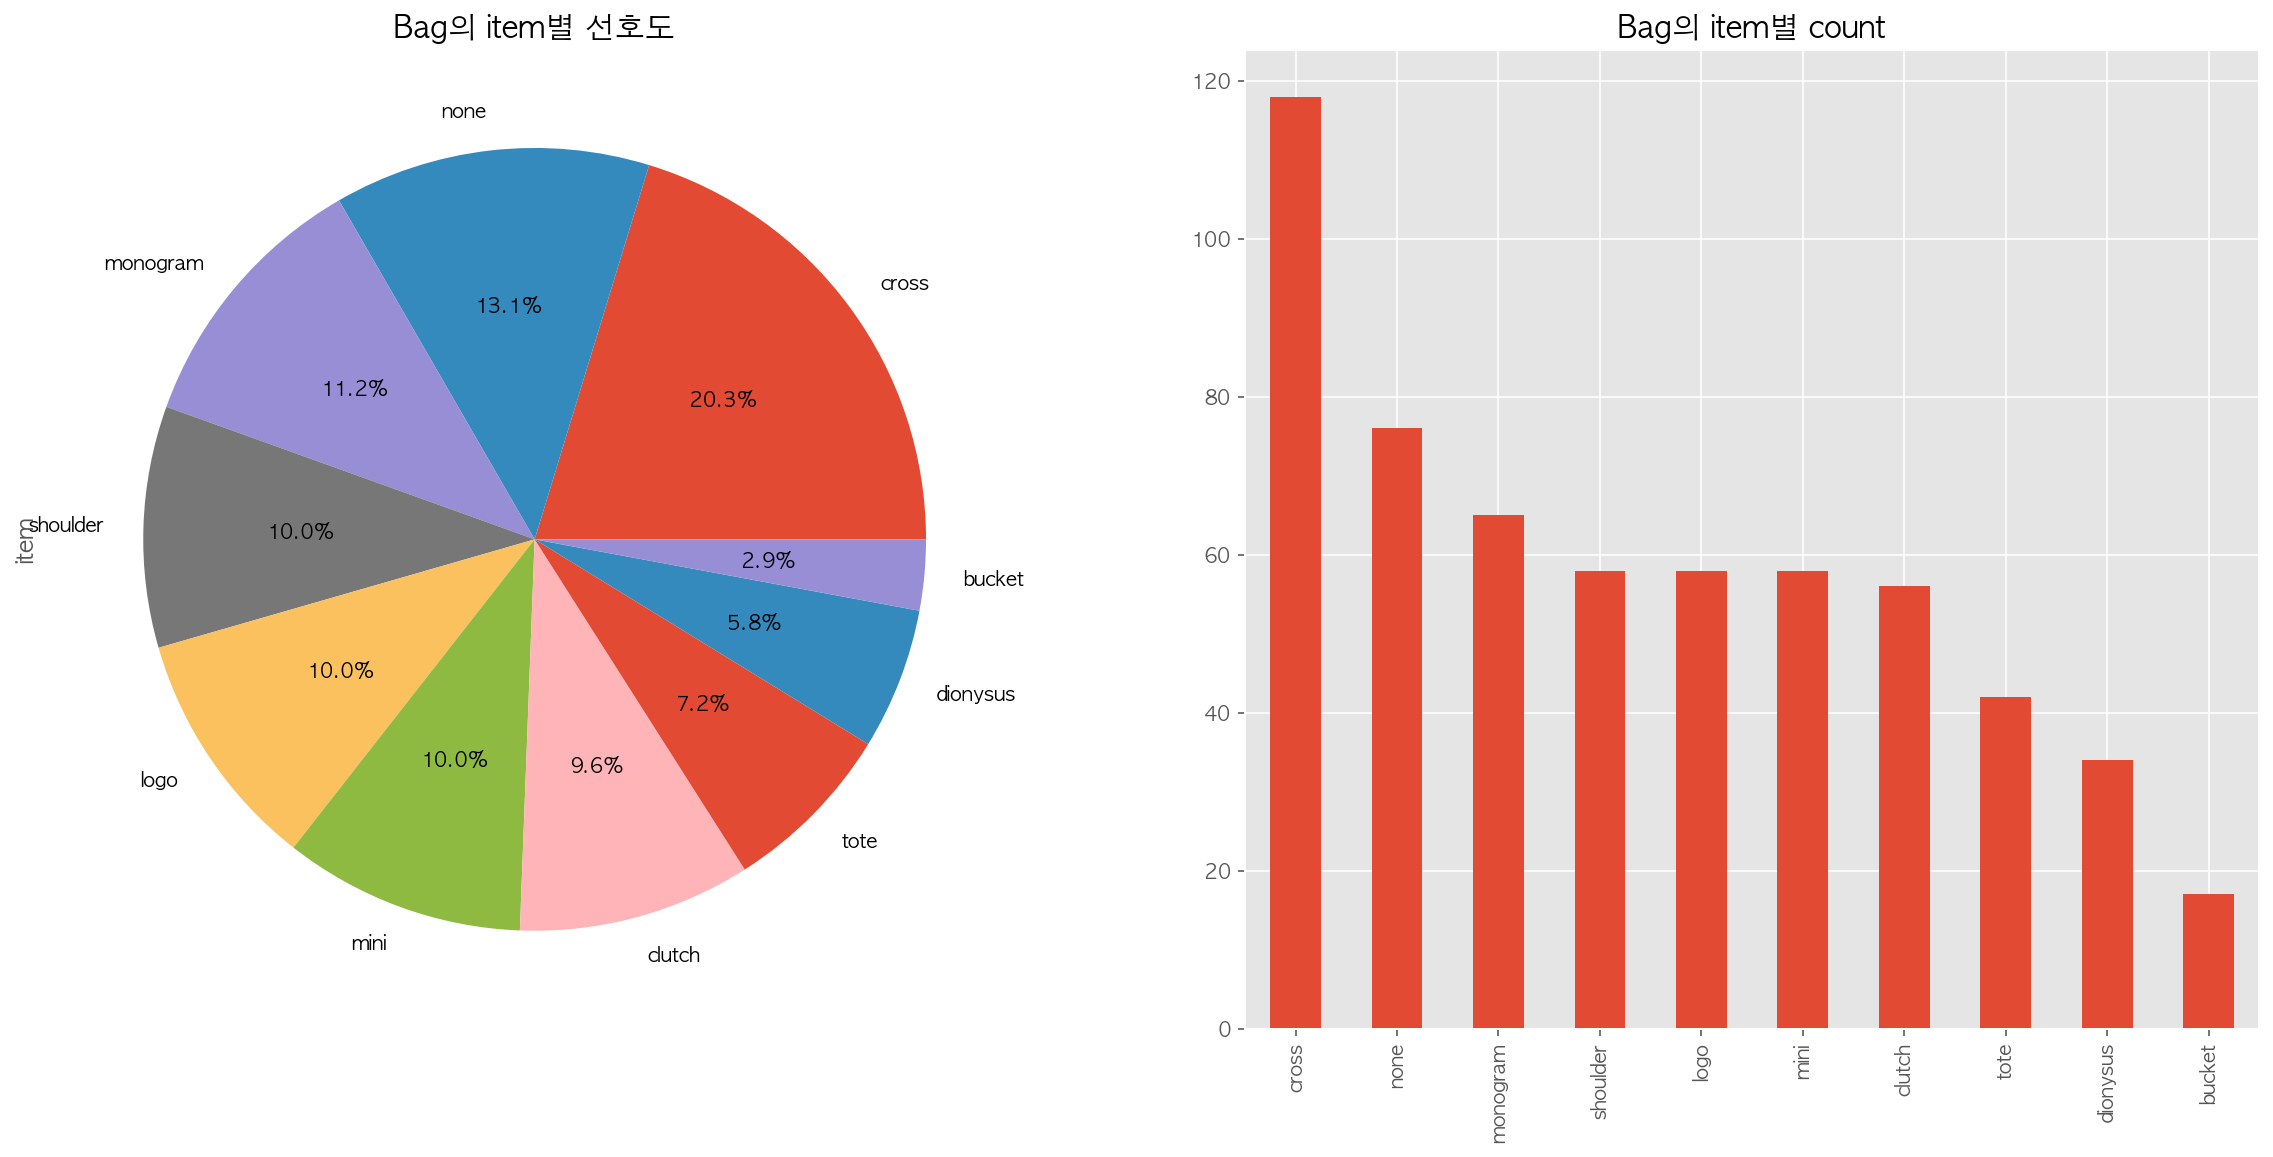

In [63]:
f, ax = plt.subplots(1,2, figsize = (20,9))

bag['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, ax=ax[0])
bag['item'].value_counts()[:10].plot(kind='bar', ax=ax[1])

ax[0].set_title("Bag의 item별 선호도", fontsize = 15)
ax[1].set_title("Bag의 item별 count", fontsize = 15)  

plt.show()

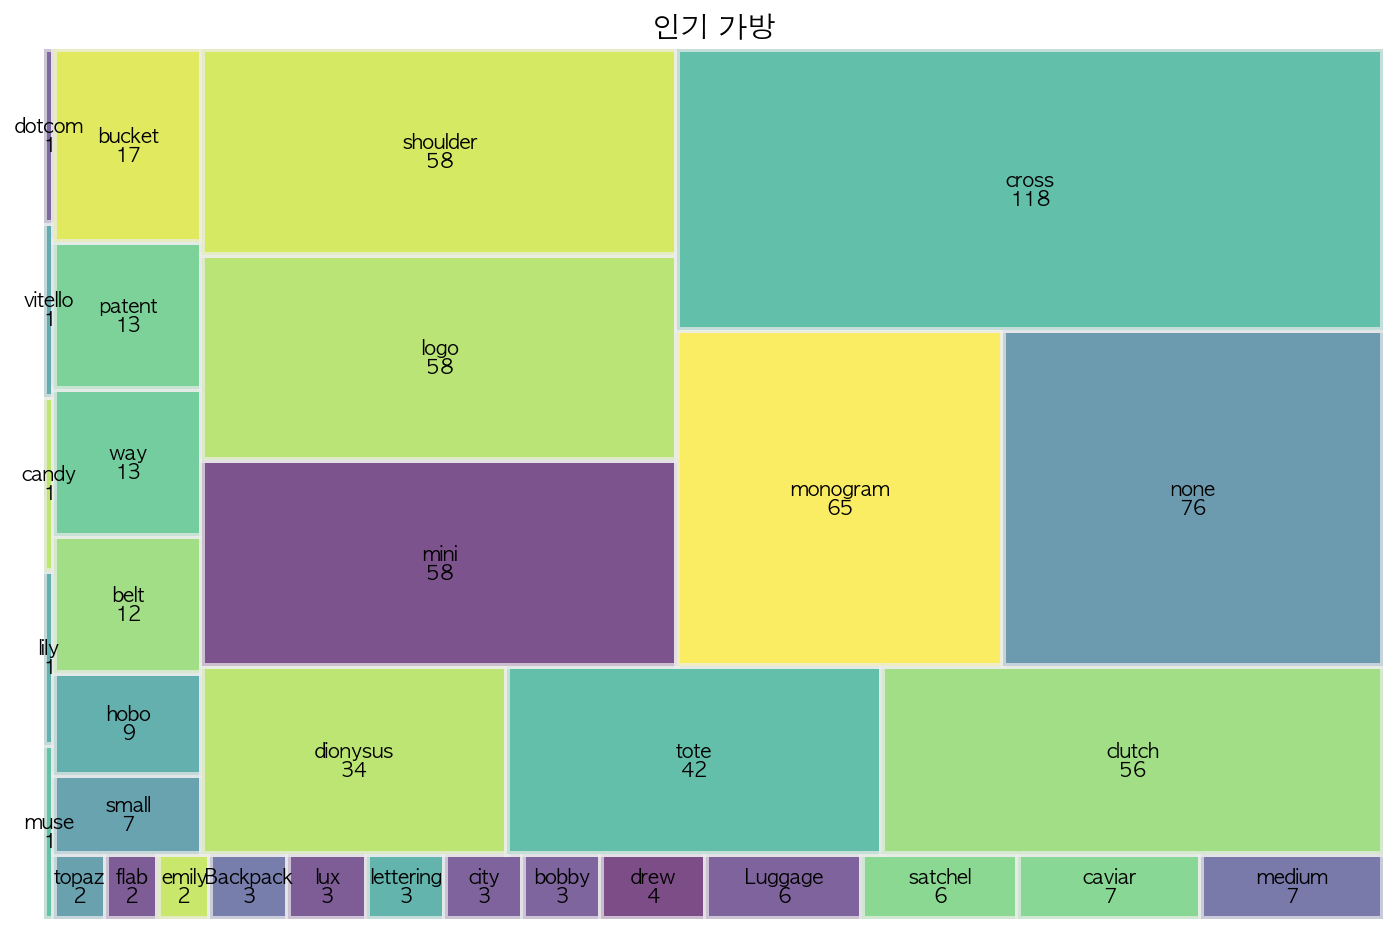

In [71]:
plt.figure(figsize=(12,8))
bag_pivot = bag.pivot_table(index = 'item', values = 'USER', aggfunc = 'count').sort_values('USER')
squarify.plot(sizes=bag_pivot['USER'], label = bag_pivot.index, value = bag_pivot['USER'], alpha=0.7,bar_kwargs=dict(linewidth=3, edgecolor="#eee"))
plt.axis('off')
plt.title('인기 가방')
plt.show()

In [72]:
# OUTER의 세부 제품 선호도 
import re
outer = data.query('sub_type=="O"').reset_index()

for i in range(len(outer)):
    outer['component'].iloc[i] = re.split(r'-| ', outer['goodsnm'][i])
    
outer['item'] = 0

def item_exit(item):
    for i in range(len(outer)):
        if (item in outer['component'][i]): 
            outer['item'].iloc[i]=item

In [74]:
outer

index                    brandnm  \
0        1        El estilo de Claire   
1        4            Burberry London   
2        5                      Prada   
3        6                   Max Mara   
4        7                  Molliolli   
5        9                     Sandro   
6       12                      Prada   
7       13                      Prada   
8       17                       Time   
9       18                  The Izzat   
10      21                  Ted Baker   
11      25                     Celine   
12      26                   Burberry   
13      31                     Sandro   
14      35                     Celine   
15      37                      Prada   
16      42        Sorry Too Much Love   
17      48                      Prada   
18      50                       Zooc   
19      53                      Prada   
20      58                     Chanel   
21      67              Saint Laurent   
22      69          Vivienne Westwood   
23      75                   Max Mara   
24      81                      Gucci   
25      82                     Celine   
26      88        Jill By Jill Stuart   
27      90                       Nain   
28      96                  Molliolli   
29     103                     Chanel   
30     106                   Max Mara   
31     107                     A.P.C.   
32     116                  Hugo Boss   
33     120                   Burberry   
34     127          Vivienne Westwood   
35     131                    Balmain   
36     132        El estilo de Claire   
37     135                     Chanel   
38     138                       Nike   
39     148                   Burberry   
40     157                     Escada   
41     162                   Diagonal   
42     164                     System   
43     168                      Chloe   
44     170                  Molliolli   
45     172                     Chanel   
46     176                      Prada   
47     179                 The Clozet   
48     197            Dolce & Gabbana   
49     209                   Burberry   
50     217                  It michaa   
51     219       Michael Michael Kors   
52     223              Spring Crocus   
53     225                      Prada   
54     227                     Theory   
55     230          Polo Ralph Lauren   
56     234                   Burberry   
57     238               ACNE STUDIOS   
58     250                   Max Mara   
59     251  Adidas X Stella Mccartney   
60     254               Wonder Style   
61     257                   Burberry   
62     270               More Or Less   
63     271                   Burberry   
64     279                     Chanel   
65     280                   khrisjoy   
66     283                  Molliolli   
67     287                 The Clozet   
68     292            Burberry London   
69     301                  Molliolli   
70     303         JDC Lucky Chouette   
71     307                      Prada   
72     315                   Burberry   
73     319                Thom Browne   
74     321            Burberry London   
75     323                     Celine   
76     324            Dolce & Gabbana   
77     328                      Prada   
78     332                Thom Browne   
79     336                     Imvely   
80     351                     Lanvin   
81     367                   Burberry   
82     375              Louis Vuitton   
83     377                      Prada   
84     378              Louis Vuitton   
85     380            Banana Republic   
86     384                   Max Mara   
87     392                Thom Browne   
88     393       Isabel Marant Etoile   
89     394                   Burberry   
90     397                     Celine   
91     400                       Akro   
92     403                Jill Stuart   
93     404                 Mojosphine   
94     406                      Fendi   
95     411                    Balmain   
96     412          Vivienne

In [76]:
outer_list = ['jacket','coat','fur','cardigan','padding','zip-up','cape','trench-coat','blazer','jumper',
             'shirts', 'blouson', 'hood']
    
for i in outer_list:
    item_exit(i)
    
# 중복처리    
for i in range(len(outer)):
    if ('zipup-jumper' in outer['component'][i]):
       outer['item'].iloc[i] = 'zip-up'
    if ('wrap-coat' in outer['component'][i]):
       outer['item'].iloc[i] = 'coat'
    if ('fullzip-jacket' in outer['component'][i]):
       outer['item'].iloc[i] = 'jacket'

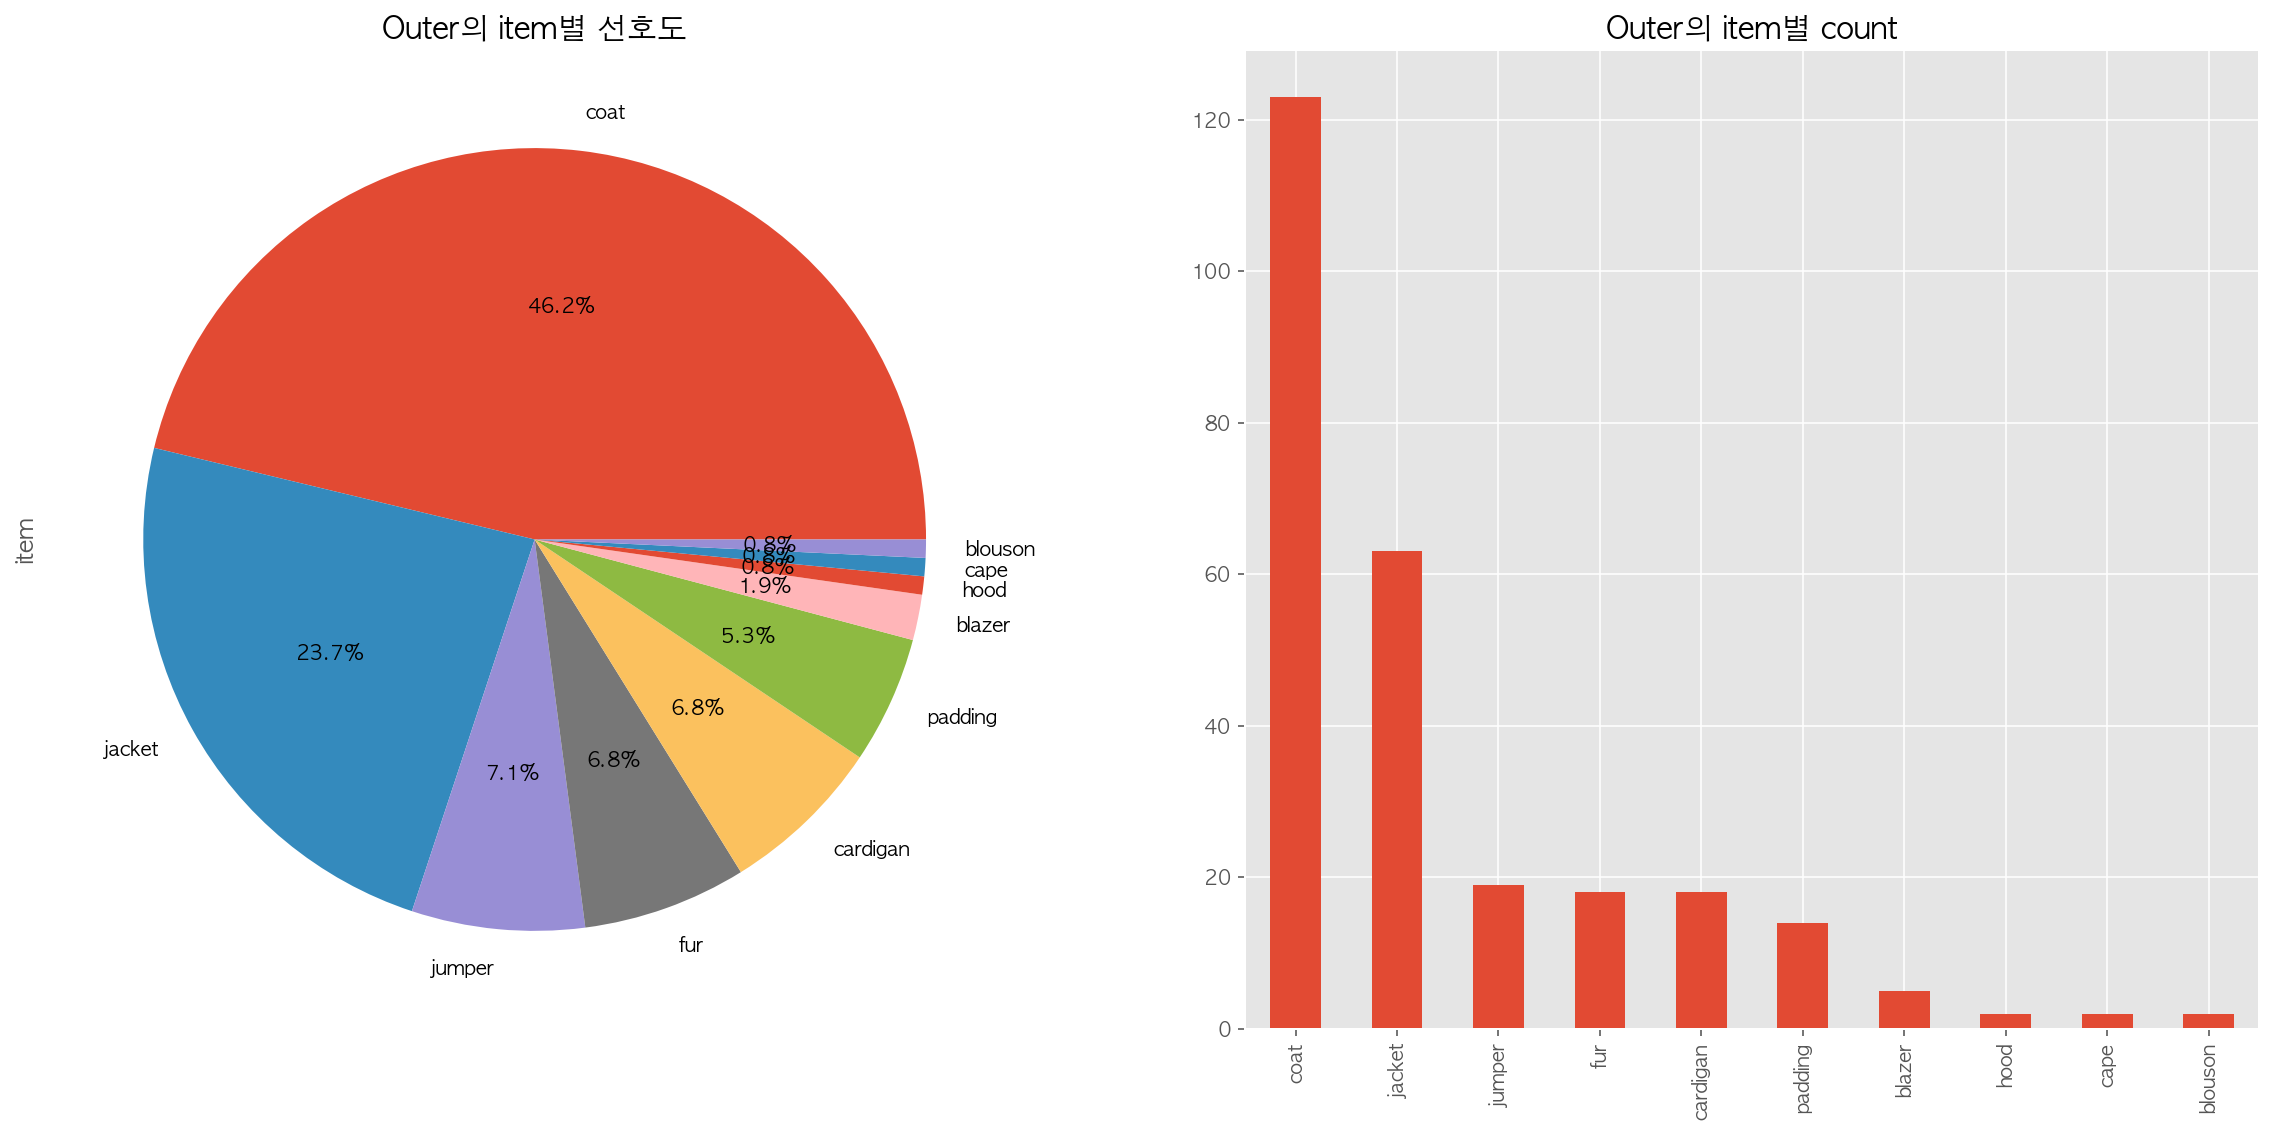

In [77]:
f, ax = plt.subplots(1,2, figsize = (20,9))

outer['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, ax=ax[0])
outer['item'].value_counts()[:10].plot(kind='bar', ax=ax[1])

ax[0].set_title("Outer의 item별 선호도", fontsize = 15)
ax[1].set_title("Outer의 item별 count", fontsize = 15)  

plt.show()

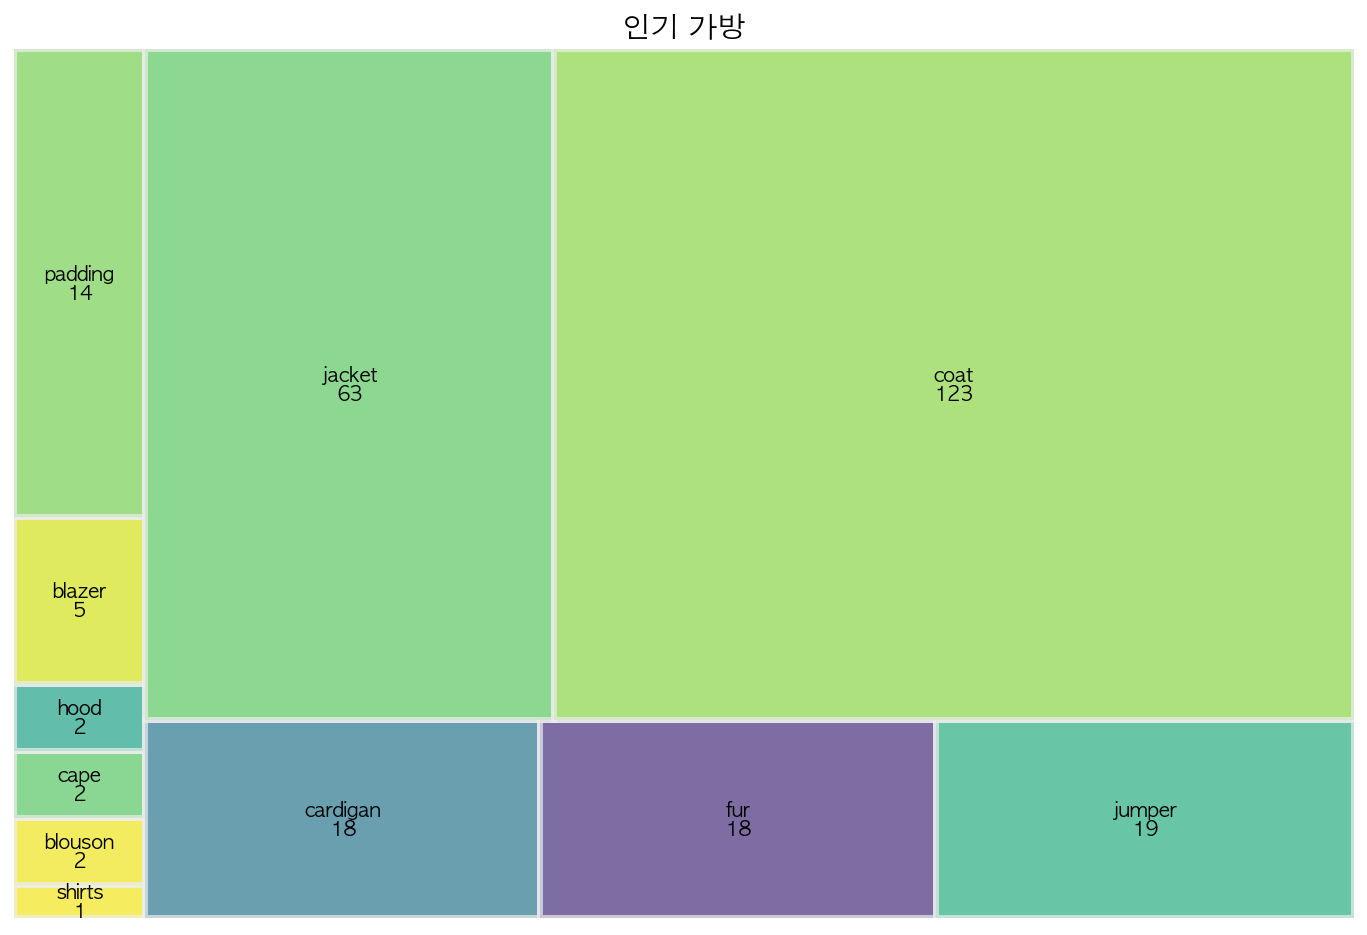

In [78]:
plt.figure(figsize=(12,8))
outer_pivot = outer.pivot_table(index = 'item', values = 'USER', aggfunc = 'count').sort_values('USER')
squarify.plot(sizes=outer_pivot['USER'], label = outer_pivot.index, value = outer_pivot['USER'], alpha=0.7,bar_kwargs=dict(linewidth=3, edgecolor="#eee"))
plt.axis('off')
plt.title('인기 가방')
plt.show()

### 첫 구매에 어떤 아이템을 구매할지 확인

In [ ]:
temp = pd.DataFrame(data.groupby(['USER','sub_type']).count()['goodsnm'].unstack())
temp.head()

In [ ]:
# user의 첫구매의 sub_type 
print("유저가 첫구매에 B를 포함할 확률:",temp['B'].notnull().sum()/len(temp))
print("유저가 첫구매에 BA를 포함할 확률:",temp['BA'].notnull().sum()/len(temp))
print("유저가 첫구매에 D를 포함할 확률:",temp['D'].notnull().sum()/len(temp))
print("유저가 첫구매에 O를 포함할 확률:",temp['O'].notnull().sum()/len(temp))
print("유저가 첫구매에 T를 포함할 확률:",temp['T'].notnull().sum()/len(temp))
print("유저가 첫구매에 TP를 포함할 확률:",temp['TP'].notnull().sum()/len(temp))

### 이런 유저들의 retention rate 및 지속적인 신규 회원 유치를 위한 action plan은 추천 시스템이라고 생각

### 가장 인기있는 피쳐들 종합 
* 색상: 검은색
* 종류: 가방
* 브랜드: 구찌

## 추천 시스템 

In [ ]:
# sub_type 별로 분리
data_ba = data[data['sub_type']=='BA']
data_o = data[data['sub_type']=='O']
data_d = data[data['sub_type']=='D']
data_t = data[data['sub_type']=='T']
data_b = data[data['sub_type']=='B']
data_tp = data[data['sub_type']=='TP']

###  sub_type = "B" 유사도 계산
- skirt와 pants를 분리하여 계산

In [ ]:
#goodsnm 벡터화
tfidf = TfidfVectorizer()

tfidf_matrix_bottom = tfidf.fit_transform(data_b['goodsnm'])
print(tfidf_matrix_bottom.shape)

In [ ]:
#코사인 유사도 측정
cosine_matrix_bottom = cosine_similarity(tfidf_matrix_bottom, tfidf_matrix_bottom)
cosine_matrix_bottom.shape

In [ ]:
# bottom dataframe을 skirt와 pants로 분리
data_skirt = data_b.loc[data_b['goodsnm'].str.contains('skirt' or 'skirts')]
data_pants = data_b.loc[data_b['goodsnm'].str.contains('skirt' or 'skirts')==False]

### sub_type별  유사도 계산

In [ ]:
# sub_type 별 cosine 유사도 함수화
def Cosine_Subtype(df_x, idx): #df_x = sub_type별 데이터프레임, idx = goodsnm 품목 명
    tfidf_matrix_sub = tfidf.fit_transform(df_x['goodsnm'])
    cosine_matrix_sub = cosine_similarity(tfidf_matrix_sub,tfidf_matrix_sub)
    np.round(cosine_matrix_sub,4)
    #딕셔너리 생성
    goods_id = {}
    for i, c in enumerate(df_x['goodsnm']): goods_id[i] = c
    #아이디 별 굿즈 이름
    id2goods = {}
    for o, p in goods_id.items(): id2goods[p] =o
    
    idx_ = id2goods[idx]
    sim_scores = [(y,z) for y, z in enumerate(cosine_matrix_sub[idx_]) if y !=idx_] 
    sim_scores = sorted(sim_scores, key =lambda x: x[1], reverse = True)
    sim_scores = [(goods_id[w], score) for w , score in sim_scores[0:15]]
    
   #중복 제거 
    my_sim_scores = []
    for v in sim_scores:
        if v not in my_sim_scores:
            my_sim_scores.append(v)
    return my_sim_scores[0:5]

### 예시

In [ ]:
# pants
Cosine_Subtype(data_b,'pocket basic pattern slacks black' )

In [ ]:
# bag
Cosine_Subtype(data_ba, 'dionysus cross bag')

In [ ]:
# outer 
Cosine_Subtype(data_o, 'pocket tweed pattern cashmere coat pink' )

In [ ]:
# top
Cosine_Subtype(data_t, 'basic pattern sweater ivory' )

In [ ]:
# dress
Cosine_Subtype(data_d, 'ruffle basic pattern A-Line dress black')